# K Nearest Neighbor

## Using train - test comparison
If we take the input of the test data and pair it to the nearest train data using a simple nearest neighbor approach, we can see if the train_data target value is the same as the target value of the test set

### Importing data splits 
It's important to get the exact same data split as used in a model, therefore we must load the data splits objects that the model has logged.

In [1]:
import sys, os
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

raw_data_path = "../raw_data/"
data_prod_path = "../data_prod/"

n = 500
k = 12
run = 6
nn_run_dir = f"../nn_runs/torch_mlp_n{n}_k{k}_run{run}/"
logfile_name = nn_run_dir + f"torchMLP_log_run{run}.txt"
logfile = open(logfile_name, mode="+a")

# Read data splits .npz file
data_splits = np.load(nn_run_dir + f"torchMLP_splits_run{run}.npz")
X_train = data_splits['X_train']
y_train = data_splits['y_train']
X_val = data_splits['X_val']
y_val = data_splits['y_val']
X_test = data_splits['X_test']
y_test = data_splits['y_test']

### Setting up the KNN
https://www.geeksforgeeks.org/machine-learning/k-nearest-neighbours/
The idea is that if we take all the train data, we can categorize it by its target value (binary hostrange 0 or 1). Then, we can iteratively assign rows from test data by a distance measurement (e.g. euclidean distance), and check if the assignment is correct from the target value of the test data. Confusion matrix can be constructed from this if we capture the instances and results of applying test data

In [2]:
class KNNClassifier:
    def __init__(self, train_data, train_label, nn_run_dir=None, logfile = None, k=3, distance_metric='euclidean', silent=True):
        self.k = k
        self.train_data = train_data
        self.train_label = train_label
        self.distance_metric = distance_metric
        
        if nn_run_dir is not None:
            self.nn_run_dir = nn_run_dir
        else:
            self.nn_run_dir = "./"
        
        self.logfile = logfile
        if self.logfile is not None:
            print("\n\n\t\t\t\t\t\t\t ####################################", file = self.logfile)
            print(f'{datetime.now().strftime("[%Y-%m-%d %H:%M:%S] ")} ### Logging for KNN started ###', file=self.logfile)
            print("\t\t\t\t\t\t\t ####################################\n", file = self.logfile)
        
        self.distance_dict = {
            'hamming': self._hamming_distance,
            'euclidean': self._euclidean_distance,
            'manhattan': self._manhattan_distance,
            'minkowski': self._minkowski_distance,
            'chebyshev': self._chebyshev_distance
        }

        self.silent = silent
    
    def predict(self, test_input):
        """
        Predict the label for a single test input. Uses a distance function to find the k nearest neighbors.
        Then, returns the most common label among those neighbors using Counter & most_common.
        """
        distances = []
        for i in range(len(self.train_data)):
            dist = self.distance_dict[self.distance_metric](test_input, self.train_data[i])
            distances.append((dist, self.train_label[i]))
        distances.sort(key=lambda x: x[0])
        k_nearest_labels = [label for _, label in distances[:self.k]]
        return Counter(k_nearest_labels).most_common(1)[0][0]

    def eval(self, test_data, test_labels):
        """ 
        Stores pred_label for accuracy, precision, recall, F1-score calculations etc. 
        Avoids having to predict multiple times.
        """
        if len(test_data) != len(test_labels):
            raise ValueError("Test data and labels must have the same length.")
        
        self.test_data = test_data
        self.test_labels = test_labels
        pred_labels = []
        print("Evaluating KNN Classifier...")
        status_code = 0
        try:
            for i in tqdm(range(len(test_data)), desc="Evaluating KNN using test data", unit=" samples/s"):
                pred_labels.append(self.predict(test_data[i]))
            self.pred_labels = np.array(pred_labels)
            return {"STATUS": status_code, "ERROR": None} 
        except Exception as e:
            status_code = 1
            return {"STATUS": status_code, "ERROR": str(e)}

    def accuracy(self):
        """ Calculates accuracy based on stored pred_labels from eval() method. """
        if not hasattr(self, 'pred_labels'):
            raise ValueError("No predictions found. Please run the eval() method first.")
        
        correct = np.sum(self.pred_labels == self.test_labels)
        return correct / len(self.test_data)
    
    def confusion_matrix(self):
        """ Generates a confusion matrix based on predictions and true labels. """
        if not hasattr(self, 'pred_labels'):
            raise ValueError("No predictions found. Please run the eval() method first.")
        
        unique_labels = np.unique(np.concatenate((self.train_label, self.test_labels)))
        label_to_index = {label: index for index, label in enumerate(unique_labels)}
        matrix_size = len(unique_labels)
        conf_matrix = np.zeros((matrix_size, matrix_size), dtype=int)
        for i in range(len(self.test_data)):
            true_label = self.test_labels[i]
            pred_label = self.pred_labels[i]
            true_index = label_to_index[true_label]
            pred_index = label_to_index[pred_label]
            conf_matrix[true_index][pred_index] += 1
        return conf_matrix, unique_labels
    
    def plot_confusion_matrix(self, cm):
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Predicted 0', 'Predicted 1'],
                    yticklabels=['True 0', 'True 1'])
        plt.title(f'Torch nn Confusion Matrix, n{n}, k{k}')
        plt.ylabel('Actual Label')
        plt.xlabel('Predicted Label')

        outname = 'knn_confusion_matrix.png'
        plt.savefig(self.nn_run_dir+outname)
        
        if self.silent is False:
            plt.show()

        if self.logfile is not None:
            print(f'{datetime.now().strftime("[%Y-%m-%d %H:%M:%S] ")} Confusion matrix figure saved as: {self.nn_run_dir+outname}', file=self.logfile)
    
    def _knn_predict_proba(self):
        """Return probability of class 1 for each sample in X using k-nearest neighbor vote proportion."""
        probs = []
        dist_fn = self.distance_dict[self.distance_metric]
        try:
            for i in range(len(self.test_data)):
                # compute distances to all train points
                dists = np.array([dist_fn(self.test_data[i], self.train_data[j]) for j in range(len(self.train_data))])
                nn_idx = np.argsort(dists)[: self.k]
                nn_labels = self.train_label[nn_idx]
                probs.append(np.mean(nn_labels == 1))  # proportion of class 1 among neighbors
            return np.array(probs)
        except Exception as e:
            raise SystemExit(f"Failed to calculate y_score in _knn_predict_proba {e}")

    def plot_roc_curve(self):
        from sklearn.metrics import roc_curve, roc_auc_score
        y_score = self._knn_predict_proba()

        # 1. Calculate AUC
        # Probabilities are needed here, not the final class prediction
        roc_auc = roc_auc_score(self.test_labels, y_score)

        # 2. Calculate the ROC curve points
        # Returns FPR, TPR, and thresholds
        fpr, tpr, thresholds = roc_curve(self.test_labels, y_score)

        # 3. Plot the ROC Curve
        plt.figure(figsize=(7, 7))
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                label=f'ROC (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--',
                label='Random Classifier') # Diagonal line for reference
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title(f'ROC Curve K n{n}, k{k}')
        plt.legend(loc="lower right")
        plt.grid(True)

        outname = 'knn_ROC.png'
        plt.savefig(self.nn_run_dir+outname)
        if self.silent is False:
            plt.show()

        if self.logfile is not None:
            print(f'{datetime.now().strftime("[%Y-%m-%d %H:%M:%S] ")} ROC curve figure saved as: {self.nn_run_dir+outname}', file=self.logfile)
    
    def f1_from_module(self, test_labels):
        """ Return f1 analysis from analysis.py """
        from analysis import f1_analysis

        # f1_analysis(y_true, y_probs, outdir, logfile)
        try: 
            f1_analysis(test_labels, self._knn_predict_proba(), 
                        outdir=self.nn_run_dir, logfile=self.logfile, 
                        filename="knn_f1_analysis.png", silent=self.silent)
            return {"STATUS": 0, "ERROR": None}
        except Exception as e:
            return {"STATUS": 1, "ERROR": str(e)}
        #displays plot and saves it in nn_run_dir


    ### Distance functions ----------------------------------------------
    def _hamming_distance(self, point1, point2):
        """ Sequential distance; Counts positions were the two sequences differ """
        return np.sum(np.array(point1) != np.array(point2))
    
    def _euclidean_distance(self, point1, point2):
        """ Spacial distance; distance between two points in Euclidean space """
        return np.sqrt(np.sum((np.array(point1) - np.array(point2))**2))
    
    def _manhattan_distance(self, point1, point2):
        """ Spacial distance; distance between two points in a grid-based path (taxi) """
        return np.sum(np.abs(np.array(point1) - np.array(point2)))
    
    def _minkowski_distance(self, point1, point2, p=3):
        return np.sum(np.abs(np.array(point1) - np.array(point2))**p)**(1/p)
    
    def _chebyshev_distance(self, point1, point2):
        return np.max(np.abs(np.array(point1) - np.array(point2)))
    

### Running KNN - 1 Input

In [3]:
# Working example
# Return a random integer from 0 to range(len(X_test))
idx = np.random.randint(0, len(X_test))
print("Randomly chose index: ", idx)
print(X_test[idx])
print(y_test[idx])

Randomly chose index:  117
[-0.67588003 -1.10568874 -1.08531346 ...  0.          0.
  0.        ]
0


In [4]:
KNNclass = KNNClassifier(X_train, y_train,
                         nn_run_dir, logfile,
                         k=6, silent=False, 
                         distance_metric='hamming'
                         )
pred_label = KNNclass.predict(X_test[0])  # Example prediction
if pred_label == y_test[0]:
    print("Correct prediction")
else:
    print("Incorrect prediction")

Correct prediction


##### Running until Incorrect Prediction

In [5]:
predict = True
counter = 0
while predict:
    idx = np.random.randint(0, len(X_test))
    print("Randomly chose index: ", idx)
    print("Test data: ", X_test[idx])
    print("True label: ", y_test[idx])
    pred_label = KNNclass.predict(X_test[idx])
    print("Predicted label: ", pred_label)
    if pred_label == y_test[idx]:
        print("Correct prediction")
        counter += 1
    else:
        print("Incorrect prediction")
        predict = False
print(f"Total correct predictions before incorrect: {counter}")

Randomly chose index:  5
Test data:  [1.47955251 0.90441366 0.92139279 ... 0.         0.         0.        ]
True label:  0
Predicted label:  0
Correct prediction
Randomly chose index:  126
Test data:  [-0.67588003 -1.10568874 -1.08531346 ...  0.          0.
  0.        ]
True label:  0
Predicted label:  0
Correct prediction
Randomly chose index:  252
Test data:  [-0.67588003 -1.10568874 -1.08531346 ...  0.          0.
  0.        ]
True label:  0
Predicted label:  0
Correct prediction
Randomly chose index:  306
Test data:  [-0.67588003 -1.10568874 -1.08531346 ...  0.          0.
  0.        ]
True label:  1
Predicted label:  0
Incorrect prediction
Total correct predictions before incorrect: 3


### Running KNN - all test 

In [6]:
eval_succes_code = KNNclass.eval(X_test, y_test)
if eval_succes_code["STATUS"] == 0:
    print("Evaluation completed successfully.")
else:
    print(f"Evaluation failed with error: {eval_succes_code['ERROR']}")
    logfile.close()
    raise SystemExit

accuracy = KNNclass.accuracy()
print(f"KNN Classifier Accuracy on Test Set: {accuracy*100:.2f}%")

Evaluating KNN Classifier...


Evaluating KNN using test data: 100%|██████████| 506/506 [00:59<00:00,  8.52 samples/s/s]

Evaluation completed successfully.
KNN Classifier Accuracy on Test Set: 92.69%


### Performance for instance: Confusion matrix, F1-analysis, ROC curves 

#### Confusion matrix

In [7]:
confusion_mat, labels = KNNclass.confusion_matrix()
print("Confusion Matrix:")
print(confusion_mat)
print("Labels:", labels)

Confusion Matrix:
[[452  15]
 [ 22  17]]
Labels: [0 1]


In [8]:
confusion_mat.flatten()

array([452,  15,  22,  17])

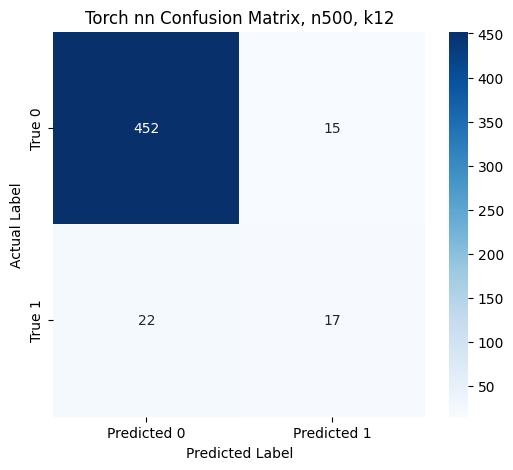

In [9]:
KNNclass.plot_confusion_matrix(confusion_mat)

#### ROC curve

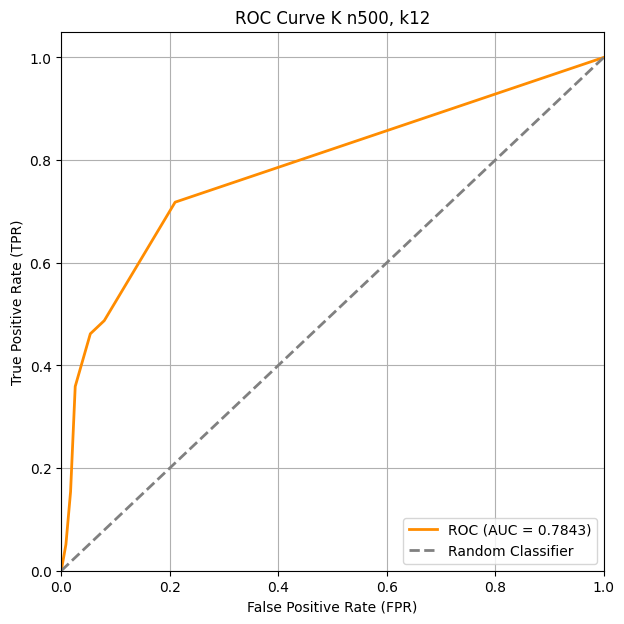

In [10]:
KNNclass.plot_roc_curve()

#### F1 analysis

Baseline (threshold=0.5) -> Precision: 0.4186, Recall: 0.4615, F1: 0.4390
Best threshold by F1 -> threshold=0.335, Precision=0.4186, Recall=0.4615, F1=0.4390

Classification report at best threshold:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       467
           1       0.42      0.46      0.44        39

    accuracy                           0.91       506
   macro avg       0.69      0.70      0.69       506
weighted avg       0.91      0.91      0.91       506

Average precision (AP): 0.2962
Confusion matrix (rows=true, cols=pred):
 [[442  25]
 [ 21  18]]


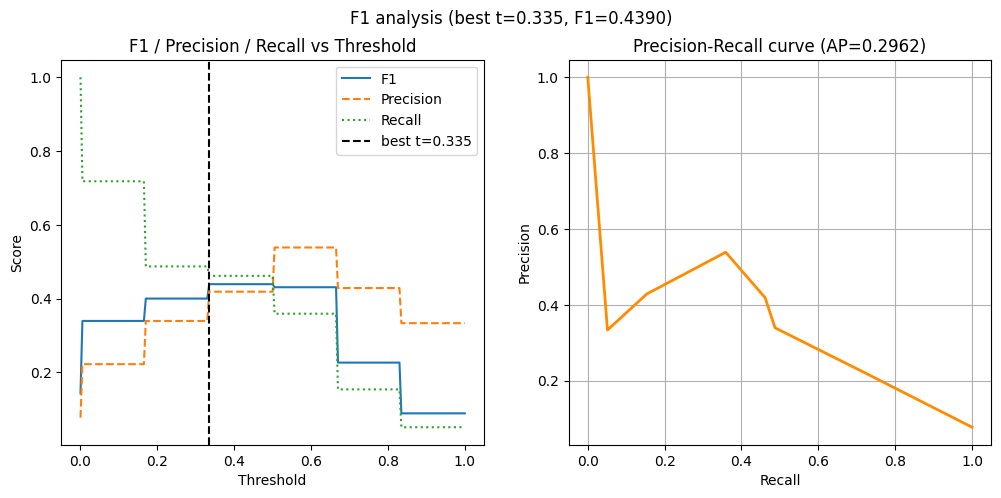

{'STATUS': 0, 'ERROR': None}


In [11]:
f1_succes_code = KNNclass.f1_from_module(y_test)
print(f1_succes_code)

## Iterate over Ks and distance functions
Finding optimal K values, writing to nn_dir

In [12]:
logfile.close()

# Code for collecting k results take a long time, 
# skip the next chunk if it has already been run previously
# (if knn_hyperparameter_search_results.csv exists in nn_run_dir)

import sys
sys.exit(1)

SystemExit: 1

/Users/asbjornhansen/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)



Iteration started on - k: 2, dist: hamming
Directory exists: ../nn_runs/torch_mlp_n500_k12_run6/knn_k2_hamming/. Overwriting files...
Evaluating KNN Classifier...


Evaluating KNN using test data: 100%|██████████| 506/506 [00:58<00:00,  8.60 samples/s/s]


KNN Classifier (k=2, distance=hamming) Accuracy on Test Set: 91.30%
Confusion matrix:
[[447  20]
 [ 24  15]]
Labels:[0 1]
Baseline (threshold=0.5) -> Precision: 0.3279, Recall: 0.5128, F1: 0.4000


/var/folders/sd/ygh_pqf56ygdrztjkzy96_s00000gn/T/ipykernel_19683/2019226211.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  collect_results = pd.concat([collect_results,


Best threshold by F1 -> threshold=0.005, Precision=0.3279, Recall=0.5128, F1=0.4000

Classification report at best threshold:
               precision    recall  f1-score   support

           0       0.96      0.91      0.93       467
           1       0.33      0.51      0.40        39

    accuracy                           0.88       506
   macro avg       0.64      0.71      0.67       506
weighted avg       0.91      0.88      0.89       506

Average precision (AP): 0.2765
Confusion matrix (rows=true, cols=pred):
 [[426  41]
 [ 19  20]]
All analysis complete, starting data collection...
Collection for k: 2, dist: hamming


Iteration started on - k: 2, dist: euclidean
Directory exists: ../nn_runs/torch_mlp_n500_k12_run6/knn_k2_euclidean/. Overwriting files...
Evaluating KNN Classifier...


Evaluating KNN using test data: 100%|██████████| 506/506 [00:41<00:00, 12.20 samples/s/s]


KNN Classifier (k=2, distance=euclidean) Accuracy on Test Set: 91.11%
Confusion matrix:
[[445  22]
 [ 23  16]]
Labels:[0 1]
Baseline (threshold=0.5) -> Precision: 0.3043, Recall: 0.5385, F1: 0.3889
Best threshold by F1 -> threshold=0.505, Precision=0.4516, Recall=0.3590, F1=0.4000

Classification report at best threshold:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       467
           1       0.45      0.36      0.40        39

    accuracy                           0.92       506
   macro avg       0.70      0.66      0.68       506
weighted avg       0.91      0.92      0.91       506

Average precision (AP): 0.2523
Confusion matrix (rows=true, cols=pred):
 [[450  17]
 [ 25  14]]
All analysis complete, starting data collection...
Collection for k: 2, dist: euclidean


Iteration started on - k: 2, dist: manhattan
Created directory: ../nn_runs/torch_mlp_n500_k12_run6/knn_k2_manhattan/. Writing new files...
Evaluating KNN Classifi

Evaluating KNN using test data: 100%|██████████| 506/506 [00:41<00:00, 12.25 samples/s/s]


KNN Classifier (k=2, distance=manhattan) Accuracy on Test Set: 89.92%
Confusion matrix:
[[440  27]
 [ 24  15]]
Labels:[0 1]
Baseline (threshold=0.5) -> Precision: 0.2933, Recall: 0.5641, F1: 0.3860
Best threshold by F1 -> threshold=0.005, Precision=0.2933, Recall=0.5641, F1=0.3860

Classification report at best threshold:
               precision    recall  f1-score   support

           0       0.96      0.89      0.92       467
           1       0.29      0.56      0.39        39

    accuracy                           0.86       506
   macro avg       0.63      0.73      0.65       506
weighted avg       0.91      0.86      0.88       506

Average precision (AP): 0.2512
Confusion matrix (rows=true, cols=pred):
 [[414  53]
 [ 17  22]]
All analysis complete, starting data collection...
Collection for k: 2, dist: manhattan


Iteration started on - k: 4, dist: hamming
Created directory: ../nn_runs/torch_mlp_n500_k12_run6/knn_k4_hamming/. Writing new files...
Evaluating KNN Classifier..

Evaluating KNN using test data: 100%|██████████| 506/506 [00:49<00:00, 10.18 samples/s/s]


KNN Classifier (k=4, distance=hamming) Accuracy on Test Set: 92.69%
Confusion matrix:
[[453  14]
 [ 23  16]]
Labels:[0 1]
Baseline (threshold=0.5) -> Precision: 0.4595, Recall: 0.4359, F1: 0.4474
Best threshold by F1 -> threshold=0.255, Precision=0.4595, Recall=0.4359, F1=0.4474

Classification report at best threshold:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       467
           1       0.46      0.44      0.45        39

    accuracy                           0.92       506
   macro avg       0.71      0.70      0.70       506
weighted avg       0.92      0.92      0.92       506

Average precision (AP): 0.2858
Confusion matrix (rows=true, cols=pred):
 [[447  20]
 [ 22  17]]
All analysis complete, starting data collection...
Collection for k: 4, dist: hamming


Iteration started on - k: 4, dist: euclidean
Created directory: ../nn_runs/torch_mlp_n500_k12_run6/knn_k4_euclidean/. Writing new files...
Evaluating KNN Classifier..

Evaluating KNN using test data: 100%|██████████| 506/506 [00:50<00:00, 10.03 samples/s/s]


KNN Classifier (k=4, distance=euclidean) Accuracy on Test Set: 91.11%
Confusion matrix:
[[445  22]
 [ 23  16]]
Labels:[0 1]
Baseline (threshold=0.5) -> Precision: 0.3478, Recall: 0.4103, F1: 0.3765
Best threshold by F1 -> threshold=0.505, Precision=0.4444, Recall=0.4103, F1=0.4267

Classification report at best threshold:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95       467
           1       0.44      0.41      0.43        39

    accuracy                           0.92       506
   macro avg       0.70      0.68      0.69       506
weighted avg       0.91      0.92      0.91       506

Average precision (AP): 0.2599
Confusion matrix (rows=true, cols=pred):
 [[447  20]
 [ 23  16]]
All analysis complete, starting data collection...
Collection for k: 4, dist: euclidean


Iteration started on - k: 4, dist: manhattan
Created directory: ../nn_runs/torch_mlp_n500_k12_run6/knn_k4_manhattan/. Writing new files...
Evaluating KNN Classifi

Evaluating KNN using test data: 100%|██████████| 506/506 [00:41<00:00, 12.32 samples/s/s]


KNN Classifier (k=4, distance=manhattan) Accuracy on Test Set: 91.30%
Confusion matrix:
[[446  21]
 [ 23  16]]
Labels:[0 1]
Baseline (threshold=0.5) -> Precision: 0.3696, Recall: 0.4359, F1: 0.4000
Best threshold by F1 -> threshold=0.505, Precision=0.4444, Recall=0.4103, F1=0.4267

Classification report at best threshold:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95       467
           1       0.44      0.41      0.43        39

    accuracy                           0.92       506
   macro avg       0.70      0.68      0.69       506
weighted avg       0.91      0.92      0.91       506

Average precision (AP): 0.2626
Confusion matrix (rows=true, cols=pred):
 [[447  20]
 [ 23  16]]
All analysis complete, starting data collection...
Collection for k: 4, dist: manhattan


Iteration started on - k: 8, dist: hamming
Created directory: ../nn_runs/torch_mlp_n500_k12_run6/knn_k8_hamming/. Writing new files...
Evaluating KNN Classifier..

Evaluating KNN using test data: 100%|██████████| 506/506 [00:49<00:00, 10.15 samples/s/s]


KNN Classifier (k=8, distance=hamming) Accuracy on Test Set: 92.09%
Confusion matrix:
[[452  15]
 [ 25  14]]
Labels:[0 1]
Baseline (threshold=0.5) -> Precision: 0.3902, Recall: 0.4103, F1: 0.4000
Best threshold by F1 -> threshold=0.255, Precision=0.3571, Recall=0.5128, F1=0.4211

Classification report at best threshold:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94       467
           1       0.36      0.51      0.42        39

    accuracy                           0.89       506
   macro avg       0.66      0.72      0.68       506
weighted avg       0.91      0.89      0.90       506

Average precision (AP): 0.2794
Confusion matrix (rows=true, cols=pred):
 [[431  36]
 [ 19  20]]


/Users/asbjornhansen/PredictPhagePPI/scripts/analysis.py:297: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 2, figsize=(12, 5))


All analysis complete, starting data collection...
Collection for k: 8, dist: hamming


Iteration started on - k: 8, dist: euclidean
Created directory: ../nn_runs/torch_mlp_n500_k12_run6/knn_k8_euclidean/. Writing new files...
Evaluating KNN Classifier...


Evaluating KNN using test data: 100%|██████████| 506/506 [00:51<00:00,  9.78 samples/s/s]


KNN Classifier (k=8, distance=euclidean) Accuracy on Test Set: 90.71%
Confusion matrix:
[[445  22]
 [ 25  14]]
Labels:[0 1]
Baseline (threshold=0.5) -> Precision: 0.3469, Recall: 0.4359, F1: 0.3864
Best threshold by F1 -> threshold=0.380, Precision=0.3469, Recall=0.4359, F1=0.3864

Classification report at best threshold:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94       467
           1       0.35      0.44      0.39        39

    accuracy                           0.89       506
   macro avg       0.65      0.68      0.66       506
weighted avg       0.91      0.89      0.90       506

Average precision (AP): 0.2607
Confusion matrix (rows=true, cols=pred):
 [[435  32]
 [ 22  17]]
All analysis complete, starting data collection...
Collection for k: 8, dist: euclidean


Iteration started on - k: 8, dist: manhattan
Created directory: ../nn_runs/torch_mlp_n500_k12_run6/knn_k8_manhattan/. Writing new files...
Evaluating KNN Classifi

Evaluating KNN using test data: 100%|██████████| 506/506 [00:41<00:00, 12.23 samples/s/s]


KNN Classifier (k=8, distance=manhattan) Accuracy on Test Set: 91.50%
Confusion matrix:
[[449  18]
 [ 25  14]]
Labels:[0 1]
Baseline (threshold=0.5) -> Precision: 0.3830, Recall: 0.4615, F1: 0.4186
Best threshold by F1 -> threshold=0.380, Precision=0.3830, Recall=0.4615, F1=0.4186

Classification report at best threshold:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95       467
           1       0.38      0.46      0.42        39

    accuracy                           0.90       506
   macro avg       0.67      0.70      0.68       506
weighted avg       0.91      0.90      0.91       506

Average precision (AP): 0.2710
Confusion matrix (rows=true, cols=pred):
 [[438  29]
 [ 21  18]]
All analysis complete, starting data collection...
Collection for k: 8, dist: manhattan


Iteration started on - k: 12, dist: hamming
Created directory: ../nn_runs/torch_mlp_n500_k12_run6/knn_k12_hamming/. Writing new files...
Evaluating KNN Classifier

Evaluating KNN using test data: 100%|██████████| 506/506 [01:00<00:00,  8.37 samples/s/s]


KNN Classifier (k=12, distance=hamming) Accuracy on Test Set: 91.50%
Confusion matrix:
[[451  16]
 [ 27  12]]
Labels:[0 1]
Baseline (threshold=0.5) -> Precision: 0.4186, Recall: 0.4615, F1: 0.4390
Best threshold by F1 -> threshold=0.420, Precision=0.4186, Recall=0.4615, F1=0.4390

Classification report at best threshold:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       467
           1       0.42      0.46      0.44        39

    accuracy                           0.91       506
   macro avg       0.69      0.70      0.69       506
weighted avg       0.91      0.91      0.91       506

Average precision (AP): 0.2768
Confusion matrix (rows=true, cols=pred):
 [[442  25]
 [ 21  18]]
All analysis complete, starting data collection...
Collection for k: 12, dist: hamming


Iteration started on - k: 12, dist: euclidean
Created directory: ../nn_runs/torch_mlp_n500_k12_run6/knn_k12_euclidean/. Writing new files...
Evaluating KNN Classifi

Evaluating KNN using test data: 100%|██████████| 506/506 [01:02<00:00,  8.08 samples/s/s]


KNN Classifier (k=12, distance=euclidean) Accuracy on Test Set: 90.32%
Confusion matrix:
[[444  23]
 [ 26  13]]
Labels:[0 1]
Baseline (threshold=0.5) -> Precision: 0.3273, Recall: 0.4615, F1: 0.3830
Best threshold by F1 -> threshold=0.420, Precision=0.3273, Recall=0.4615, F1=0.3830

Classification report at best threshold:
               precision    recall  f1-score   support

           0       0.95      0.92      0.94       467
           1       0.33      0.46      0.38        39

    accuracy                           0.89       506
   macro avg       0.64      0.69      0.66       506
weighted avg       0.91      0.89      0.89       506

Average precision (AP): 0.2567
Confusion matrix (rows=true, cols=pred):
 [[430  37]
 [ 21  18]]
All analysis complete, starting data collection...
Collection for k: 12, dist: euclidean


Iteration started on - k: 12, dist: manhattan
Created directory: ../nn_runs/torch_mlp_n500_k12_run6/knn_k12_manhattan/. Writing new files...
Evaluating KNN Clas

Evaluating KNN using test data: 100%|██████████| 506/506 [00:40<00:00, 12.56 samples/s/s]


KNN Classifier (k=12, distance=manhattan) Accuracy on Test Set: 90.51%
Confusion matrix:
[[445  22]
 [ 26  13]]
Labels:[0 1]
Baseline (threshold=0.5) -> Precision: 0.3673, Recall: 0.4615, F1: 0.4091
Best threshold by F1 -> threshold=0.420, Precision=0.3673, Recall=0.4615, F1=0.4091

Classification report at best threshold:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94       467
           1       0.37      0.46      0.41        39

    accuracy                           0.90       506
   macro avg       0.66      0.70      0.68       506
weighted avg       0.91      0.90      0.90       506

Average precision (AP): 0.2733
Confusion matrix (rows=true, cols=pred):
 [[436  31]
 [ 21  18]]
All analysis complete, starting data collection...
Collection for k: 12, dist: manhattan


Iteration started on - k: 14, dist: hamming
Created directory: ../nn_runs/torch_mlp_n500_k12_run6/knn_k14_hamming/. Writing new files...
Evaluating KNN Classifi

Evaluating KNN using test data: 100%|██████████| 506/506 [00:40<00:00, 12.63 samples/s/s]


KNN Classifier (k=14, distance=hamming) Accuracy on Test Set: 91.90%
Confusion matrix:
[[456  11]
 [ 30   9]]
Labels:[0 1]
Baseline (threshold=0.5) -> Precision: 0.3636, Recall: 0.3077, F1: 0.3333
Best threshold by F1 -> threshold=0.360, Precision=0.3750, Recall=0.4615, F1=0.4138

Classification report at best threshold:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94       467
           1       0.38      0.46      0.41        39

    accuracy                           0.90       506
   macro avg       0.66      0.70      0.68       506
weighted avg       0.91      0.90      0.90       506

Average precision (AP): 0.2769
Confusion matrix (rows=true, cols=pred):
 [[437  30]
 [ 21  18]]
All analysis complete, starting data collection...
Collection for k: 14, dist: hamming


Iteration started on - k: 14, dist: euclidean
Created directory: ../nn_runs/torch_mlp_n500_k12_run6/knn_k14_euclidean/. Writing new files...
Evaluating KNN Classifi

Evaluating KNN using test data: 100%|██████████| 506/506 [00:36<00:00, 13.97 samples/s/s]


KNN Classifier (k=14, distance=euclidean) Accuracy on Test Set: 90.71%
Confusion matrix:
[[450  17]
 [ 30   9]]
Labels:[0 1]
Baseline (threshold=0.5) -> Precision: 0.2895, Recall: 0.2821, F1: 0.2857
Best threshold by F1 -> threshold=0.360, Precision=0.3134, Recall=0.5385, F1=0.3962

Classification report at best threshold:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93       467
           1       0.31      0.54      0.40        39

    accuracy                           0.87       506
   macro avg       0.64      0.72      0.66       506
weighted avg       0.91      0.87      0.89       506

Average precision (AP): 0.2379
Confusion matrix (rows=true, cols=pred):
 [[421  46]
 [ 18  21]]
All analysis complete, starting data collection...
Collection for k: 14, dist: euclidean


Iteration started on - k: 14, dist: manhattan
Created directory: ../nn_runs/torch_mlp_n500_k12_run6/knn_k14_manhattan/. Writing new files...
Evaluating KNN Clas

Evaluating KNN using test data: 100%|██████████| 506/506 [00:35<00:00, 14.10 samples/s/s]


KNN Classifier (k=14, distance=manhattan) Accuracy on Test Set: 91.11%
Confusion matrix:
[[452  15]
 [ 30   9]]
Labels:[0 1]
Baseline (threshold=0.5) -> Precision: 0.3235, Recall: 0.2821, F1: 0.3014
Best threshold by F1 -> threshold=0.360, Precision=0.3103, Recall=0.4615, F1=0.3711

Classification report at best threshold:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93       467
           1       0.31      0.46      0.37        39

    accuracy                           0.88       506
   macro avg       0.63      0.69      0.65       506
weighted avg       0.90      0.88      0.89       506

Average precision (AP): 0.2645
Confusion matrix (rows=true, cols=pred):
 [[427  40]
 [ 21  18]]
All analysis complete, starting data collection...
Collection for k: 14, dist: manhattan


Iteration started on - k: 18, dist: hamming
Created directory: ../nn_runs/torch_mlp_n500_k12_run6/knn_k18_hamming/. Writing new files...
Evaluating KNN Classifi

Evaluating KNN using test data: 100%|██████████| 506/506 [00:36<00:00, 13.72 samples/s/s]


KNN Classifier (k=18, distance=hamming) Accuracy on Test Set: 92.09%
Confusion matrix:
[[458   9]
 [ 31   8]]
Labels:[0 1]
Baseline (threshold=0.5) -> Precision: 0.4091, Recall: 0.2308, F1: 0.2951
Best threshold by F1 -> threshold=0.280, Precision=0.2879, Recall=0.4872, F1=0.3619

Classification report at best threshold:
               precision    recall  f1-score   support

           0       0.95      0.90      0.93       467
           1       0.29      0.49      0.36        39

    accuracy                           0.87       506
   macro avg       0.62      0.69      0.64       506
weighted avg       0.90      0.87      0.88       506

Average precision (AP): 0.2788
Confusion matrix (rows=true, cols=pred):
 [[420  47]
 [ 20  19]]
All analysis complete, starting data collection...
Collection for k: 18, dist: hamming


Iteration started on - k: 18, dist: euclidean
Created directory: ../nn_runs/torch_mlp_n500_k12_run6/knn_k18_euclidean/. Writing new files...
Evaluating KNN Classifi

Evaluating KNN using test data: 100%|██████████| 506/506 [00:32<00:00, 15.43 samples/s/s]


KNN Classifier (k=18, distance=euclidean) Accuracy on Test Set: 92.09%
Confusion matrix:
[[458   9]
 [ 31   8]]
Labels:[0 1]
Baseline (threshold=0.5) -> Precision: 0.3913, Recall: 0.2308, F1: 0.2903
Best threshold by F1 -> threshold=0.335, Precision=0.2895, Recall=0.5641, F1=0.3826

Classification report at best threshold:
               precision    recall  f1-score   support

           0       0.96      0.88      0.92       467
           1       0.29      0.56      0.38        39

    accuracy                           0.86       506
   macro avg       0.62      0.72      0.65       506
weighted avg       0.91      0.86      0.88       506

Average precision (AP): 0.2781
Confusion matrix (rows=true, cols=pred):
 [[413  54]
 [ 17  22]]
All analysis complete, starting data collection...
Collection for k: 18, dist: euclidean


Iteration started on - k: 18, dist: manhattan
Created directory: ../nn_runs/torch_mlp_n500_k12_run6/knn_k18_manhattan/. Writing new files...
Evaluating KNN Clas

Evaluating KNN using test data: 100%|██████████| 506/506 [00:34<00:00, 14.65 samples/s/s]


KNN Classifier (k=18, distance=manhattan) Accuracy on Test Set: 91.50%
Confusion matrix:
[[456  11]
 [ 32   7]]
Labels:[0 1]
Baseline (threshold=0.5) -> Precision: 0.3333, Recall: 0.2051, F1: 0.2540
Best threshold by F1 -> threshold=0.280, Precision=0.3012, Recall=0.6410, F1=0.4098

Classification report at best threshold:
               precision    recall  f1-score   support

           0       0.97      0.88      0.92       467
           1       0.30      0.64      0.41        39

    accuracy                           0.86       506
   macro avg       0.63      0.76      0.66       506
weighted avg       0.92      0.86      0.88       506

Average precision (AP): 0.2900
Confusion matrix (rows=true, cols=pred):
 [[409  58]
 [ 14  25]]
All analysis complete, starting data collection...
Collection for k: 18, dist: manhattan


Iteration started on - k: 36, dist: hamming
Created directory: ../nn_runs/torch_mlp_n500_k12_run6/knn_k36_hamming/. Writing new files...
Evaluating KNN Classifi

Evaluating KNN using test data: 100%|██████████| 506/506 [00:32<00:00, 15.50 samples/s/s]


KNN Classifier (k=36, distance=hamming) Accuracy on Test Set: 91.90%
Confusion matrix:
[[460   7]
 [ 34   5]]
Labels:[0 1]
Baseline (threshold=0.5) -> Precision: 0.4167, Recall: 0.1282, F1: 0.1961
Best threshold by F1 -> threshold=0.280, Precision=0.4412, Recall=0.3846, F1=0.4110

Classification report at best threshold:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95       467
           1       0.44      0.38      0.41        39

    accuracy                           0.92       506
   macro avg       0.70      0.67      0.68       506
weighted avg       0.91      0.92      0.91       506

Average precision (AP): 0.2845
Confusion matrix (rows=true, cols=pred):
 [[448  19]
 [ 24  15]]
All analysis complete, starting data collection...
Collection for k: 36, dist: hamming


Iteration started on - k: 36, dist: euclidean
Created directory: ../nn_runs/torch_mlp_n500_k12_run6/knn_k36_euclidean/. Writing new files...
Evaluating KNN Classifi

Evaluating KNN using test data: 100%|██████████| 506/506 [00:33<00:00, 15.32 samples/s/s]


KNN Classifier (k=36, distance=euclidean) Accuracy on Test Set: 92.49%
Confusion matrix:
[[465   2]
 [ 36   3]]
Labels:[0 1]
Baseline (threshold=0.5) -> Precision: 0.6000, Recall: 0.0769, F1: 0.1364
Best threshold by F1 -> threshold=0.335, Precision=0.5000, Recall=0.3077, F1=0.3810

Classification report at best threshold:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96       467
           1       0.50      0.31      0.38        39

    accuracy                           0.92       506
   macro avg       0.72      0.64      0.67       506
weighted avg       0.91      0.92      0.91       506

Average precision (AP): 0.3361
Confusion matrix (rows=true, cols=pred):
 [[455  12]
 [ 27  12]]
All analysis complete, starting data collection...
Collection for k: 36, dist: euclidean


Iteration started on - k: 36, dist: manhattan
Created directory: ../nn_runs/torch_mlp_n500_k12_run6/knn_k36_manhattan/. Writing new files...
Evaluating KNN Clas

Evaluating KNN using test data: 100%|██████████| 506/506 [00:30<00:00, 16.72 samples/s/s]


KNN Classifier (k=36, distance=manhattan) Accuracy on Test Set: 91.90%
Confusion matrix:
[[460   7]
 [ 34   5]]
Labels:[0 1]
Baseline (threshold=0.5) -> Precision: 0.4167, Recall: 0.1282, F1: 0.1961
Best threshold by F1 -> threshold=0.335, Precision=0.5357, Recall=0.3846, F1=0.4478

Classification report at best threshold:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       467
           1       0.54      0.38      0.45        39

    accuracy                           0.93       506
   macro avg       0.74      0.68      0.70       506
weighted avg       0.92      0.93      0.92       506

Average precision (AP): 0.3331
Confusion matrix (rows=true, cols=pred):
 [[454  13]
 [ 24  15]]
All analysis complete, starting data collection...
Collection for k: 36, dist: manhattan


Iteration started on - k: 52, dist: hamming
Created directory: ../nn_runs/torch_mlp_n500_k12_run6/knn_k52_hamming/. Writing new files...
Evaluating KNN Classifi

Evaluating KNN using test data: 100%|██████████| 506/506 [00:32<00:00, 15.60 samples/s/s]


KNN Classifier (k=52, distance=hamming) Accuracy on Test Set: 91.90%
Confusion matrix:
[[461   6]
 [ 35   4]]
Labels:[0 1]
Baseline (threshold=0.5) -> Precision: 0.4000, Recall: 0.1026, F1: 0.1633
Best threshold by F1 -> threshold=0.255, Precision=0.4222, Recall=0.4872, F1=0.4524

Classification report at best threshold:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95       467
           1       0.42      0.49      0.45        39

    accuracy                           0.91       506
   macro avg       0.69      0.72      0.70       506
weighted avg       0.92      0.91      0.91       506

Average precision (AP): 0.3152
Confusion matrix (rows=true, cols=pred):
 [[441  26]
 [ 20  19]]
All analysis complete, starting data collection...
Collection for k: 52, dist: hamming


Iteration started on - k: 52, dist: euclidean
Created directory: ../nn_runs/torch_mlp_n500_k12_run6/knn_k52_euclidean/. Writing new files...
Evaluating KNN Classifi

Evaluating KNN using test data: 100%|██████████| 506/506 [00:28<00:00, 17.57 samples/s/s]


KNN Classifier (k=52, distance=euclidean) Accuracy on Test Set: 91.90%
Confusion matrix:
[[463   4]
 [ 37   2]]
Labels:[0 1]
Baseline (threshold=0.5) -> Precision: 0.3333, Recall: 0.0513, F1: 0.0889
Best threshold by F1 -> threshold=0.290, Precision=0.4222, Recall=0.4872, F1=0.4524

Classification report at best threshold:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95       467
           1       0.42      0.49      0.45        39

    accuracy                           0.91       506
   macro avg       0.69      0.72      0.70       506
weighted avg       0.92      0.91      0.91       506

Average precision (AP): 0.3006
Confusion matrix (rows=true, cols=pred):
 [[441  26]
 [ 20  19]]
All analysis complete, starting data collection...
Collection for k: 52, dist: euclidean


Iteration started on - k: 52, dist: manhattan
Created directory: ../nn_runs/torch_mlp_n500_k12_run6/knn_k52_manhattan/. Writing new files...
Evaluating KNN Clas

Evaluating KNN using test data: 100%|██████████| 506/506 [00:31<00:00, 16.24 samples/s/s]


KNN Classifier (k=52, distance=manhattan) Accuracy on Test Set: 91.90%
Confusion matrix:
[[463   4]
 [ 37   2]]
Labels:[0 1]
Baseline (threshold=0.5) -> Precision: 0.3333, Recall: 0.0513, F1: 0.0889
Best threshold by F1 -> threshold=0.270, Precision=0.4737, Recall=0.4615, F1=0.4675

Classification report at best threshold:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       467
           1       0.47      0.46      0.47        39

    accuracy                           0.92       506
   macro avg       0.71      0.71      0.71       506
weighted avg       0.92      0.92      0.92       506

Average precision (AP): 0.3233
Confusion matrix (rows=true, cols=pred):
 [[447  20]
 [ 21  18]]
All analysis complete, starting data collection...
Collection for k: 52, dist: manhattan


Iteration started on - k: 72, dist: hamming
Created directory: ../nn_runs/torch_mlp_n500_k12_run6/knn_k72_hamming/. Writing new files...
Evaluating KNN Classifi

Evaluating KNN using test data: 100%|██████████| 506/506 [00:30<00:00, 16.57 samples/s/s]


KNN Classifier (k=72, distance=hamming) Accuracy on Test Set: 91.90%
Confusion matrix:
[[461   6]
 [ 35   4]]
Labels:[0 1]
Baseline (threshold=0.5) -> Precision: 0.4615, Recall: 0.1538, F1: 0.2308
Best threshold by F1 -> threshold=0.225, Precision=0.3056, Recall=0.5641, F1=0.3964

Classification report at best threshold:
               precision    recall  f1-score   support

           0       0.96      0.89      0.93       467
           1       0.31      0.56      0.40        39

    accuracy                           0.87       506
   macro avg       0.63      0.73      0.66       506
weighted avg       0.91      0.87      0.88       506

Average precision (AP): 0.2938
Confusion matrix (rows=true, cols=pred):
 [[417  50]
 [ 17  22]]
All analysis complete, starting data collection...
Collection for k: 72, dist: hamming


Iteration started on - k: 72, dist: euclidean
Created directory: ../nn_runs/torch_mlp_n500_k12_run6/knn_k72_euclidean/. Writing new files...
Evaluating KNN Classifi

Evaluating KNN using test data: 100%|██████████| 506/506 [00:28<00:00, 17.82 samples/s/s]


KNN Classifier (k=72, distance=euclidean) Accuracy on Test Set: 92.69%
Confusion matrix:
[[467   0]
 [ 37   2]]
Labels:[0 1]
Baseline (threshold=0.5) -> Precision: 1.0000, Recall: 0.0513, F1: 0.0976
Best threshold by F1 -> threshold=0.350, Precision=0.5000, Recall=0.3846, F1=0.4348

Classification report at best threshold:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       467
           1       0.50      0.38      0.43        39

    accuracy                           0.92       506
   macro avg       0.72      0.68      0.70       506
weighted avg       0.91      0.92      0.92       506

Average precision (AP): 0.3085
Confusion matrix (rows=true, cols=pred):
 [[452  15]
 [ 24  15]]
All analysis complete, starting data collection...
Collection for k: 72, dist: euclidean


Iteration started on - k: 72, dist: manhattan
Created directory: ../nn_runs/torch_mlp_n500_k12_run6/knn_k72_manhattan/. Writing new files...
Evaluating KNN Clas

Evaluating KNN using test data: 100%|██████████| 506/506 [00:31<00:00, 16.24 samples/s/s]


KNN Classifier (k=72, distance=manhattan) Accuracy on Test Set: 92.29%
Confusion matrix:
[[465   2]
 [ 37   2]]
Labels:[0 1]
Baseline (threshold=0.5) -> Precision: 0.5000, Recall: 0.0513, F1: 0.0930
Best threshold by F1 -> threshold=0.365, Precision=0.5000, Recall=0.3590, F1=0.4179

Classification report at best threshold:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       467
           1       0.50      0.36      0.42        39

    accuracy                           0.92       506
   macro avg       0.72      0.66      0.69       506
weighted avg       0.91      0.92      0.92       506

Average precision (AP): 0.3062
Confusion matrix (rows=true, cols=pred):
 [[453  14]
 [ 25  14]]
All analysis complete, starting data collection...
Collection for k: 72, dist: manhattan


Iteration started on - k: 96, dist: hamming
Created directory: ../nn_runs/torch_mlp_n500_k12_run6/knn_k96_hamming/. Writing new files...
Evaluating KNN Classifi

Evaluating KNN using test data: 100%|██████████| 506/506 [00:31<00:00, 16.16 samples/s/s]


KNN Classifier (k=96, distance=hamming) Accuracy on Test Set: 92.29%
Confusion matrix:
[[467   0]
 [ 39   0]]
Labels:[0 1]
Baseline (threshold=0.5) -> Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Best threshold by F1 -> threshold=0.265, Precision=0.3265, Recall=0.4103, F1=0.3636

Classification report at best threshold:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94       467
           1       0.33      0.41      0.36        39

    accuracy                           0.89       506
   macro avg       0.64      0.67      0.65       506
weighted avg       0.90      0.89      0.90       506

Average precision (AP): 0.2928
Confusion matrix (rows=true, cols=pred):
 [[434  33]
 [ 23  16]]
All analysis complete, starting data collection...
Collection for k: 96, dist: hamming


Iteration started on - k: 96, dist: euclidean
Created directory: ../nn_runs/torch_mlp_n500_k12_run6/knn_k96_euclidean/. Writing new files...
Evaluating KNN Classifi

Evaluating KNN using test data: 100%|██████████| 506/506 [00:32<00:00, 15.42 samples/s/s]


KNN Classifier (k=96, distance=euclidean) Accuracy on Test Set: 92.89%
Confusion matrix:
[[467   0]
 [ 36   3]]
Labels:[0 1]
Baseline (threshold=0.5) -> Precision: 1.0000, Recall: 0.0769, F1: 0.1429
Best threshold by F1 -> threshold=0.295, Precision=0.1667, Recall=0.5385, F1=0.2545

Classification report at best threshold:
               precision    recall  f1-score   support

           0       0.95      0.78      0.85       467
           1       0.17      0.54      0.25        39

    accuracy                           0.76       506
   macro avg       0.56      0.66      0.55       506
weighted avg       0.89      0.76      0.81       506

Average precision (AP): 0.2428
Confusion matrix (rows=true, cols=pred):
 [[362 105]
 [ 18  21]]
All analysis complete, starting data collection...
Collection for k: 96, dist: euclidean


Iteration started on - k: 96, dist: manhattan
Created directory: ../nn_runs/torch_mlp_n500_k12_run6/knn_k96_manhattan/. Writing new files...
Evaluating KNN Clas

Evaluating KNN using test data: 100%|██████████| 506/506 [00:28<00:00, 17.86 samples/s/s]


KNN Classifier (k=96, distance=manhattan) Accuracy on Test Set: 93.08%
Confusion matrix:
[[467   0]
 [ 35   4]]
Labels:[0 1]
Baseline (threshold=0.5) -> Precision: 1.0000, Recall: 0.1026, F1: 0.1860
Best threshold by F1 -> threshold=0.265, Precision=0.1681, Recall=0.5128, F1=0.2532

Classification report at best threshold:
               precision    recall  f1-score   support

           0       0.95      0.79      0.86       467
           1       0.17      0.51      0.25        39

    accuracy                           0.77       506
   macro avg       0.56      0.65      0.56       506
weighted avg       0.89      0.77      0.81       506

Average precision (AP): 0.2388
Confusion matrix (rows=true, cols=pred):
 [[368  99]
 [ 19  20]]
All analysis complete, starting data collection...
Collection for k: 96, dist: manhattan


Iteration started on - k: 120, dist: hamming
Created directory: ../nn_runs/torch_mlp_n500_k12_run6/knn_k120_hamming/. Writing new files...
Evaluating KNN Classi

Evaluating KNN using test data: 100%|██████████| 506/506 [00:30<00:00, 16.55 samples/s/s]


KNN Classifier (k=120, distance=hamming) Accuracy on Test Set: 92.29%
Confusion matrix:
[[467   0]
 [ 39   0]]
Labels:[0 1]
Baseline (threshold=0.5) -> Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Best threshold by F1 -> threshold=0.310, Precision=0.4375, Recall=0.3590, F1=0.3944

Classification report at best threshold:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95       467
           1       0.44      0.36      0.39        39

    accuracy                           0.92       506
   macro avg       0.69      0.66      0.67       506
weighted avg       0.91      0.92      0.91       506

Average precision (AP): 0.3110
Confusion matrix (rows=true, cols=pred):
 [[449  18]
 [ 25  14]]
All analysis complete, starting data collection...
Collection for k: 120, dist: hamming


Iteration started on - k: 120, dist: euclidean
Created directory: ../nn_runs/torch_mlp_n500_k12_run6/knn_k120_euclidean/. Writing new files...
Evaluating KNN Clas

Evaluating KNN using test data: 100%|██████████| 506/506 [00:31<00:00, 15.98 samples/s/s]


KNN Classifier (k=120, distance=euclidean) Accuracy on Test Set: 92.29%
Confusion matrix:
[[467   0]
 [ 39   0]]
Labels:[0 1]
Baseline (threshold=0.5) -> Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Best threshold by F1 -> threshold=0.405, Precision=0.5833, Recall=0.1795, F1=0.2745

Classification report at best threshold:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96       467
           1       0.58      0.18      0.27        39

    accuracy                           0.93       506
   macro avg       0.76      0.58      0.62       506
weighted avg       0.91      0.93      0.91       506

Average precision (AP): 0.2609
Confusion matrix (rows=true, cols=pred):
 [[462   5]
 [ 32   7]]
All analysis complete, starting data collection...
Collection for k: 120, dist: euclidean


Iteration started on - k: 120, dist: manhattan
Created directory: ../nn_runs/torch_mlp_n500_k12_run6/knn_k120_manhattan/. Writing new files...
Evaluating KNN 

Evaluating KNN using test data: 100%|██████████| 506/506 [00:30<00:00, 16.53 samples/s/s]


KNN Classifier (k=120, distance=manhattan) Accuracy on Test Set: 92.29%
Confusion matrix:
[[467   0]
 [ 39   0]]
Labels:[0 1]
Baseline (threshold=0.5) -> Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Best threshold by F1 -> threshold=0.310, Precision=0.1957, Recall=0.4615, F1=0.2748

Classification report at best threshold:
               precision    recall  f1-score   support

           0       0.95      0.84      0.89       467
           1       0.20      0.46      0.27        39

    accuracy                           0.81       506
   macro avg       0.57      0.65      0.58       506
weighted avg       0.89      0.81      0.84       506

Average precision (AP): 0.2540
Confusion matrix (rows=true, cols=pred):
 [[393  74]
 [ 21  18]]
All analysis complete, starting data collection...
Collection for k: 120, dist: manhattan



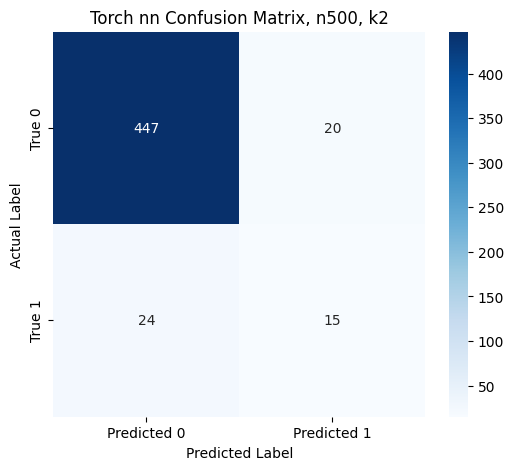

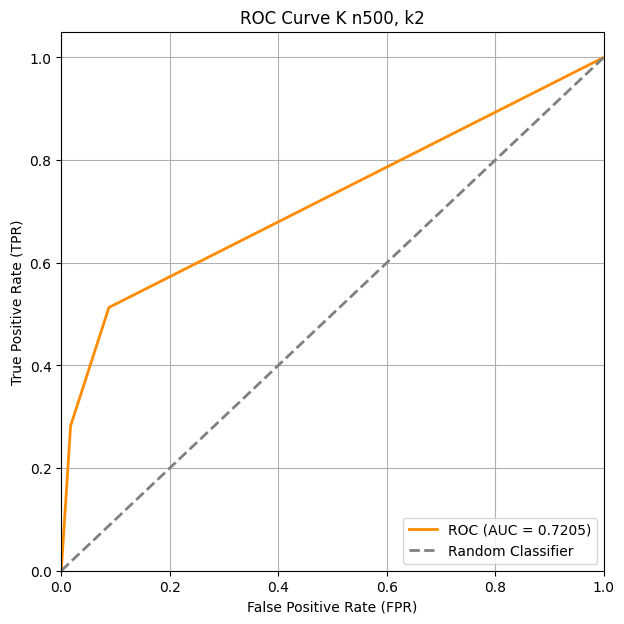

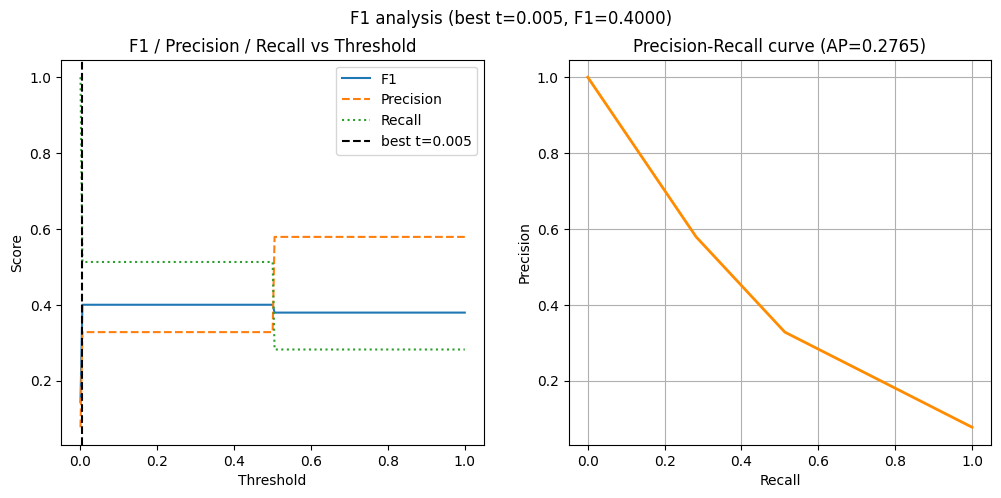

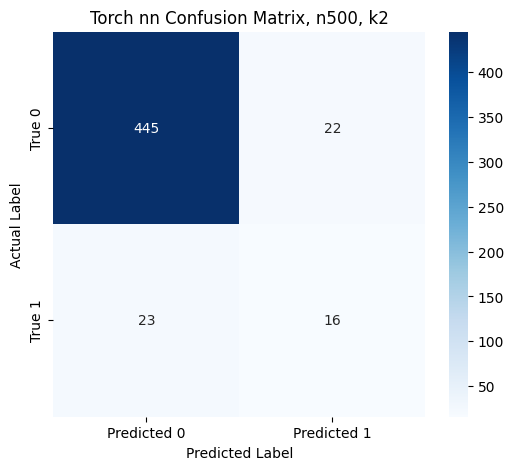

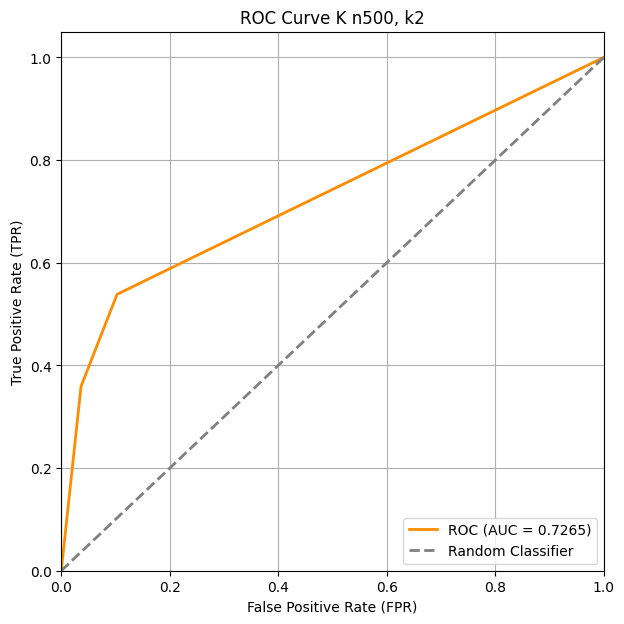

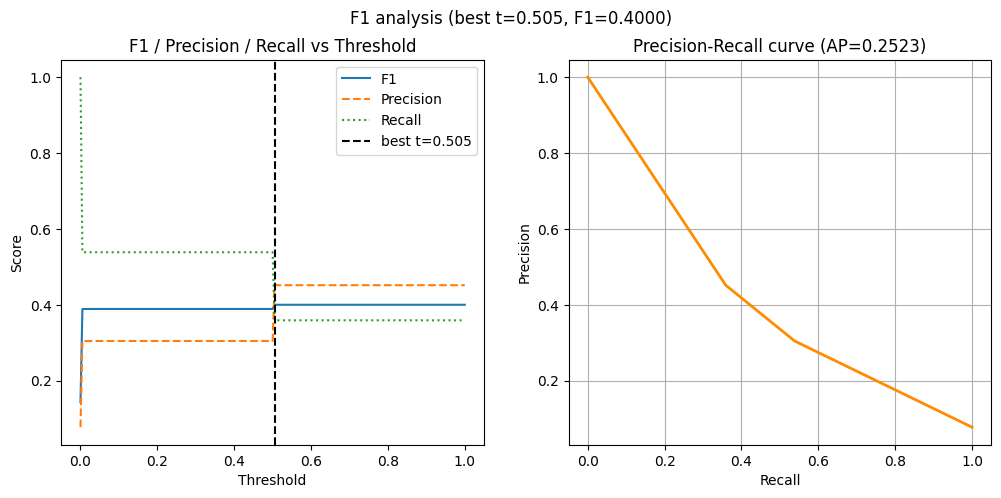

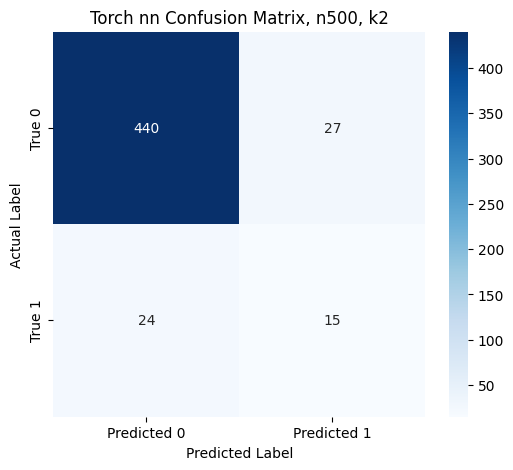

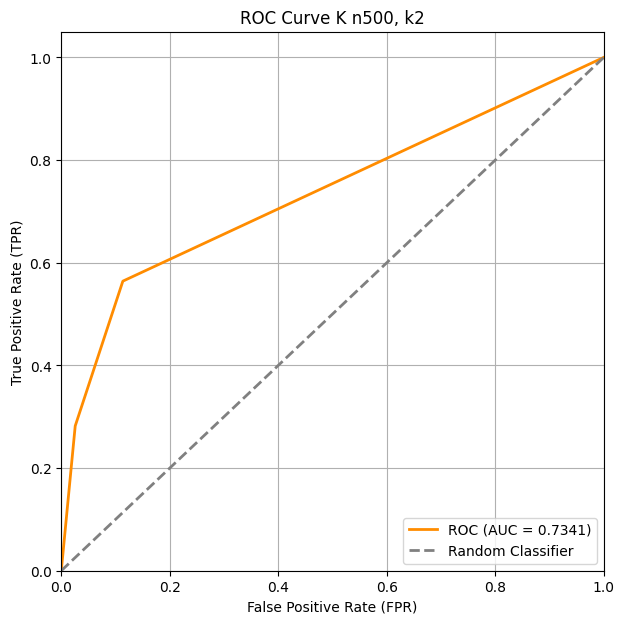

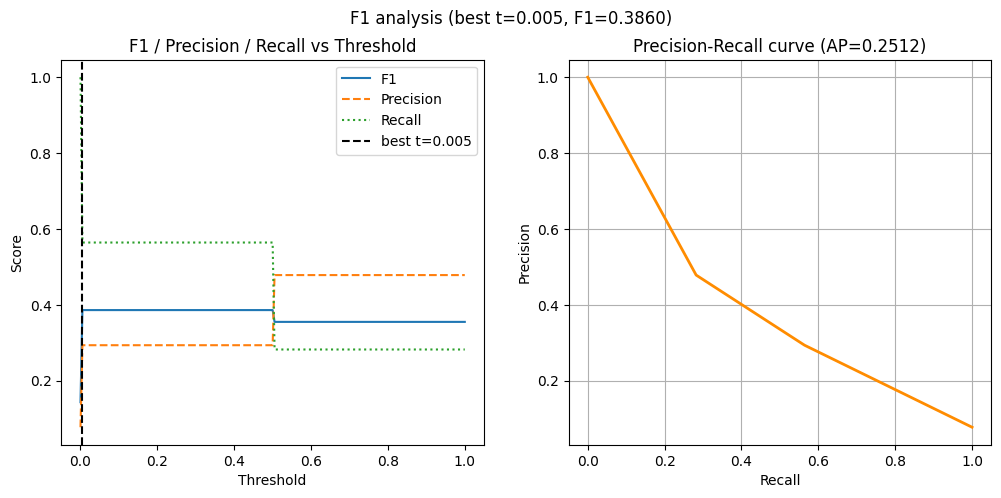

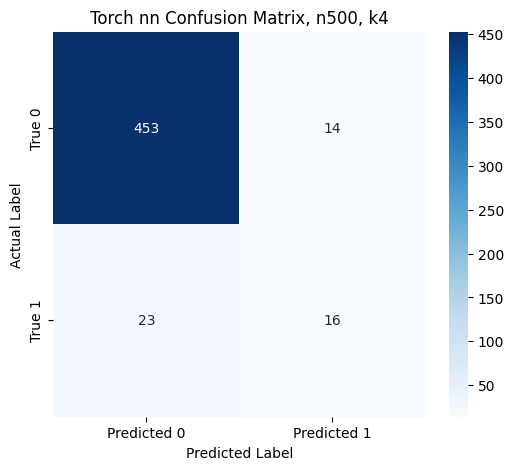

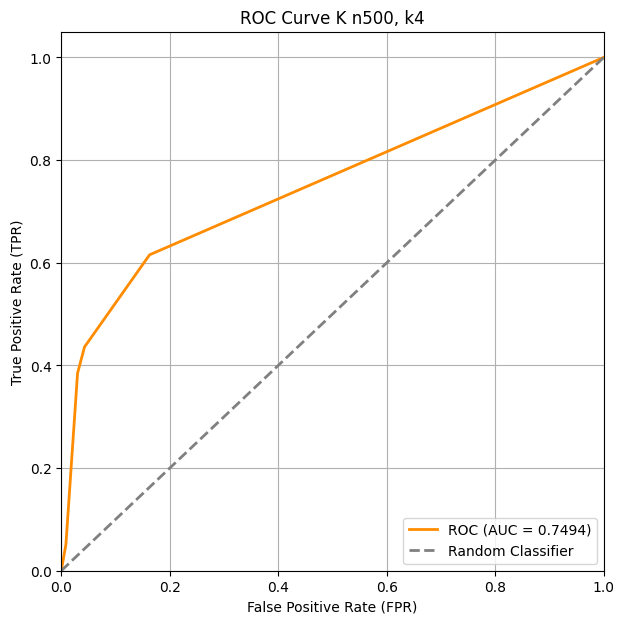

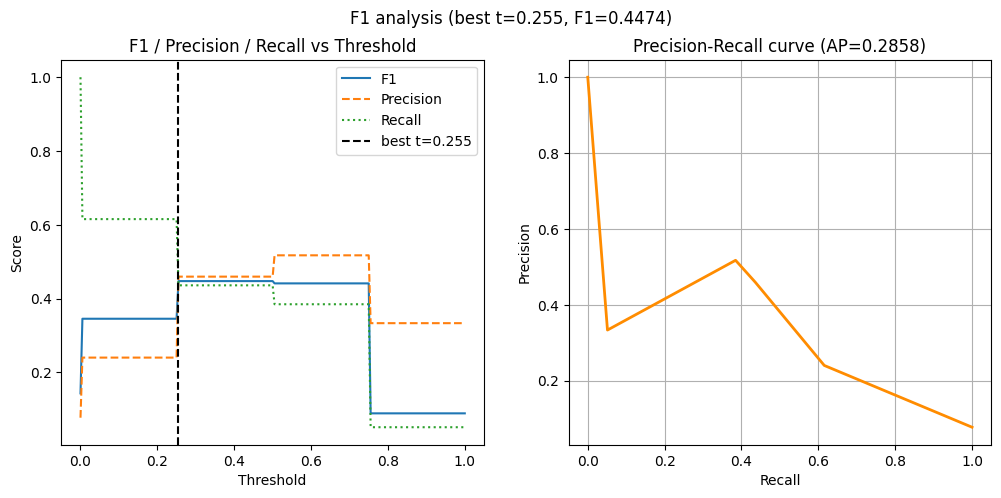

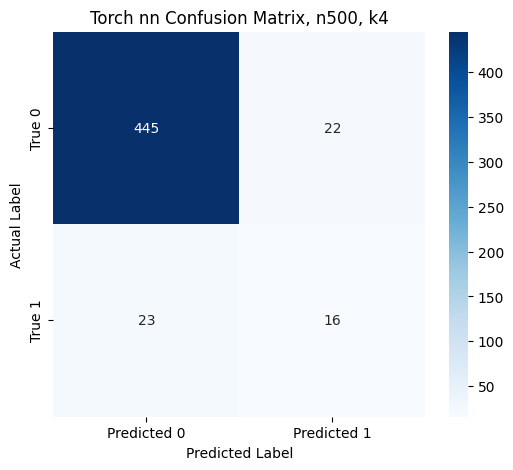

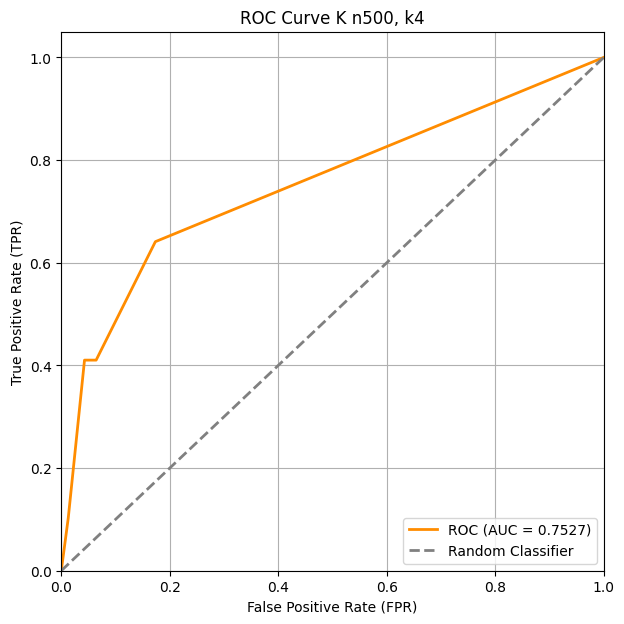

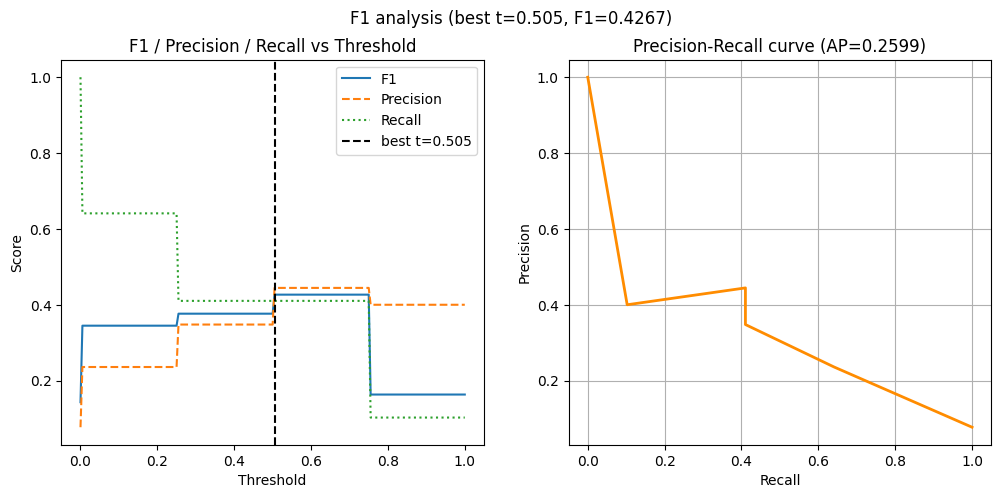

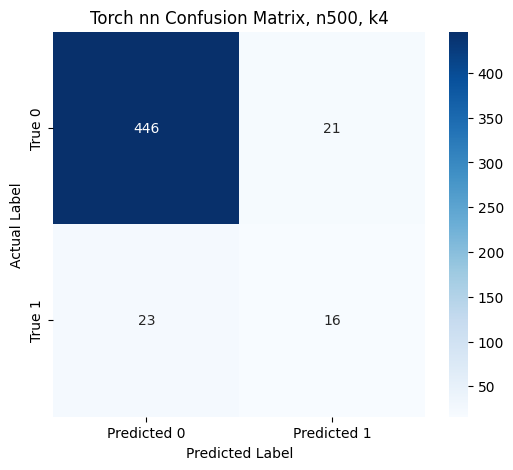

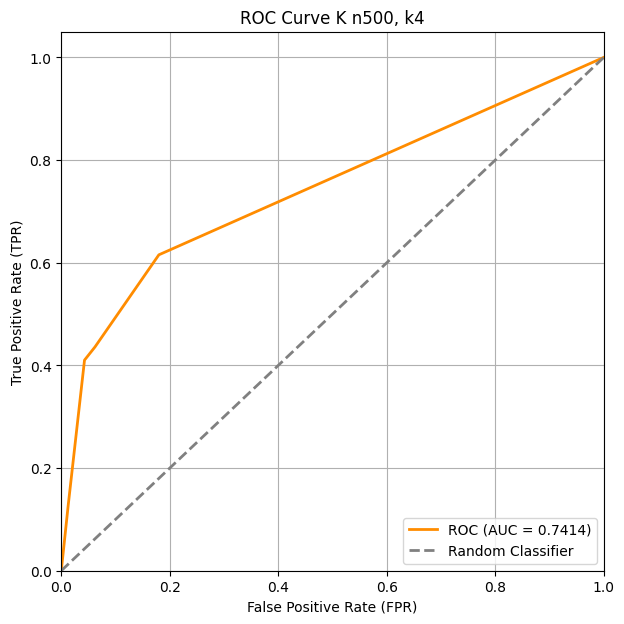

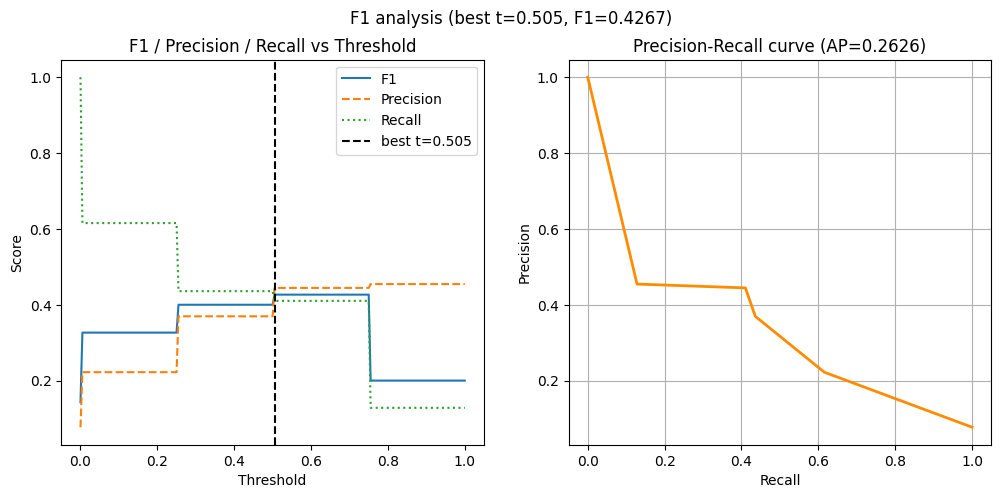

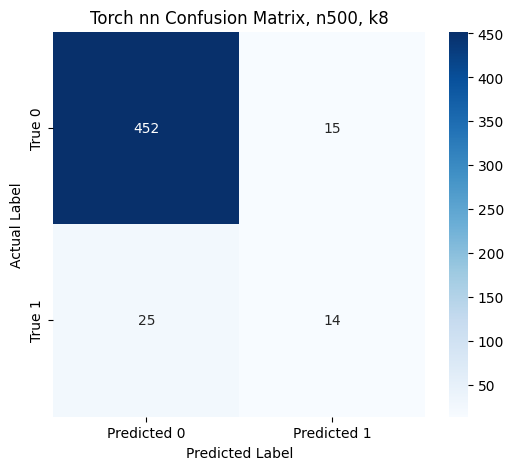

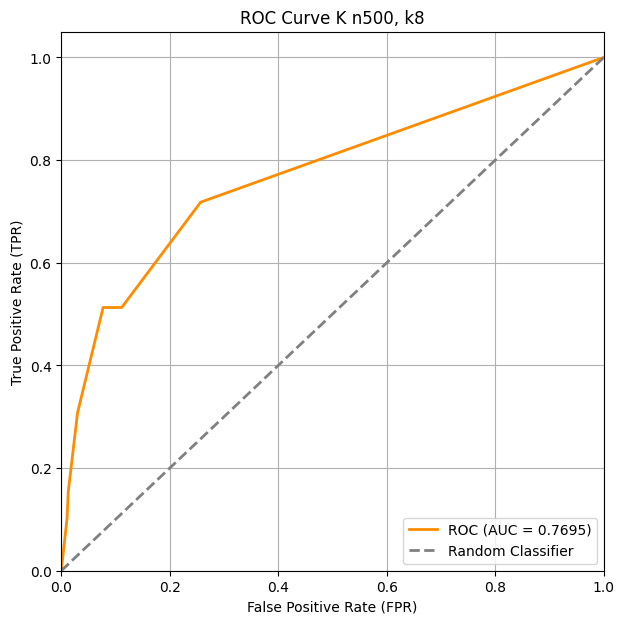

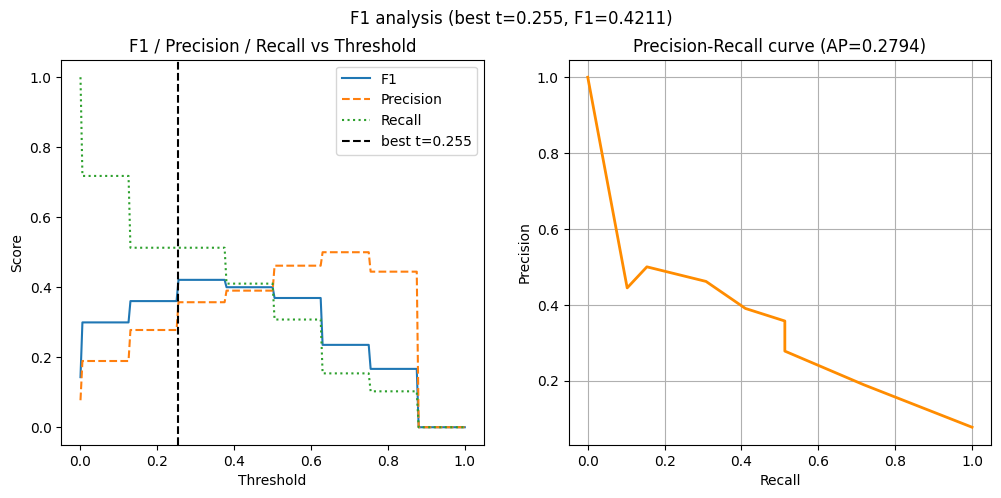

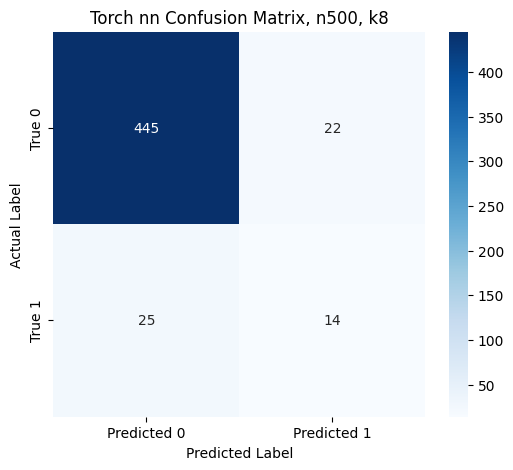

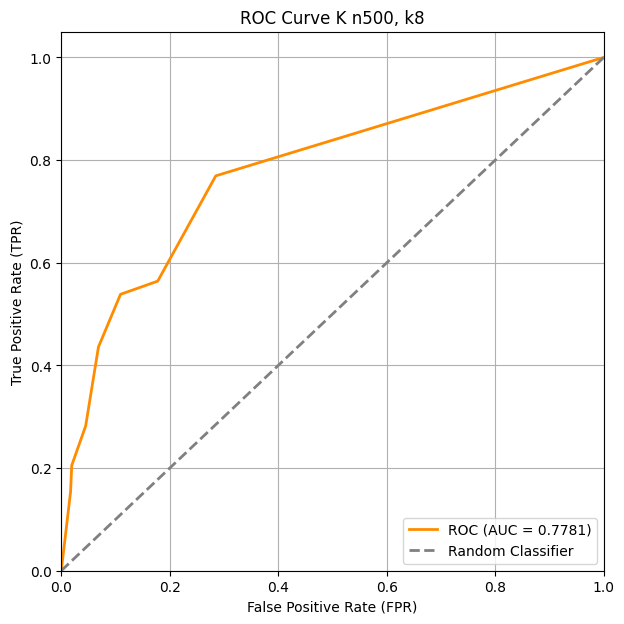

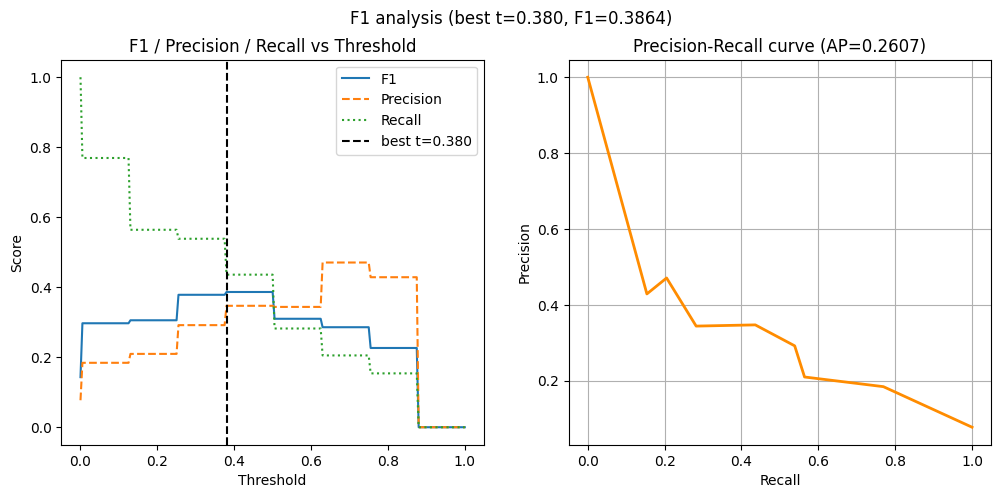

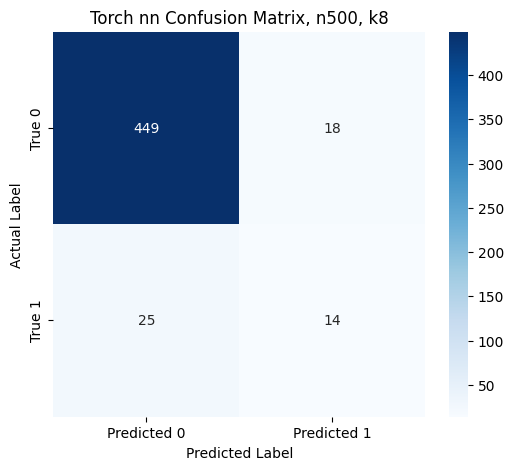

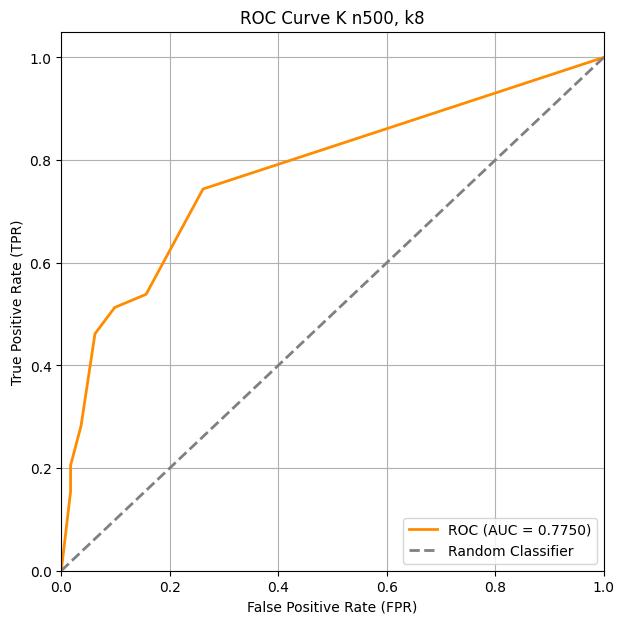

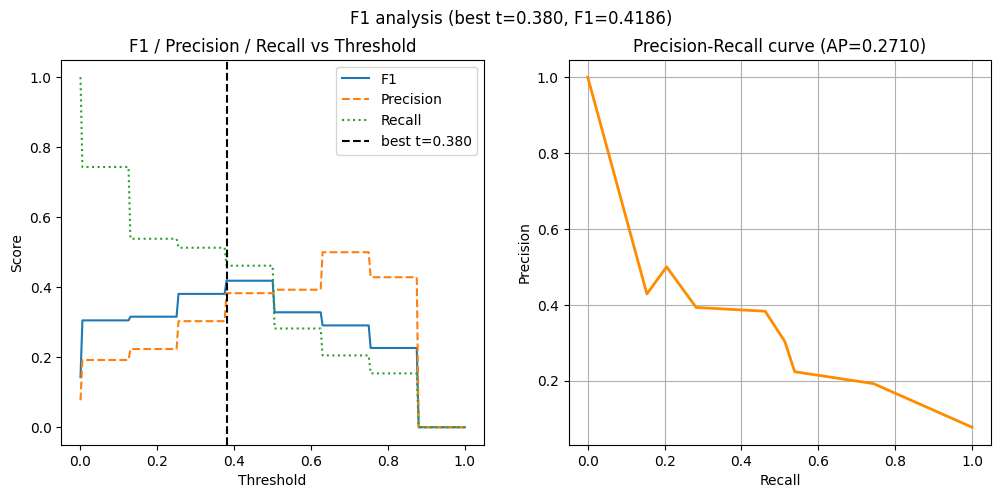

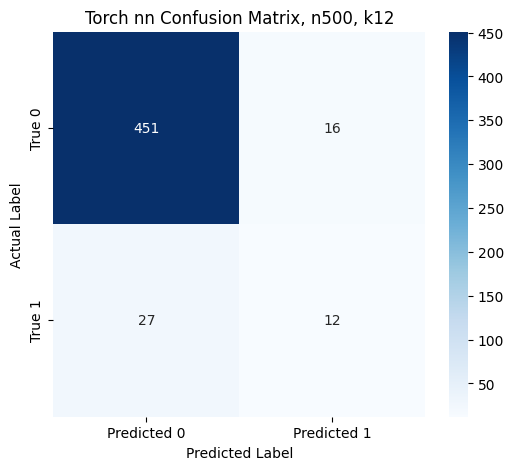

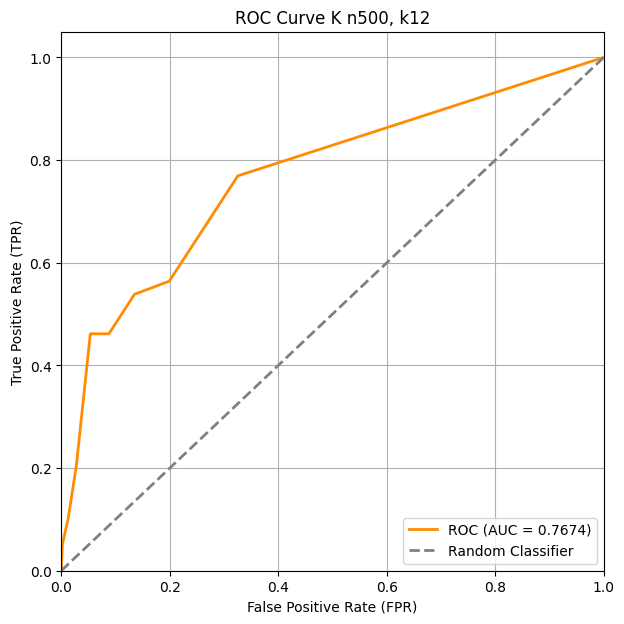

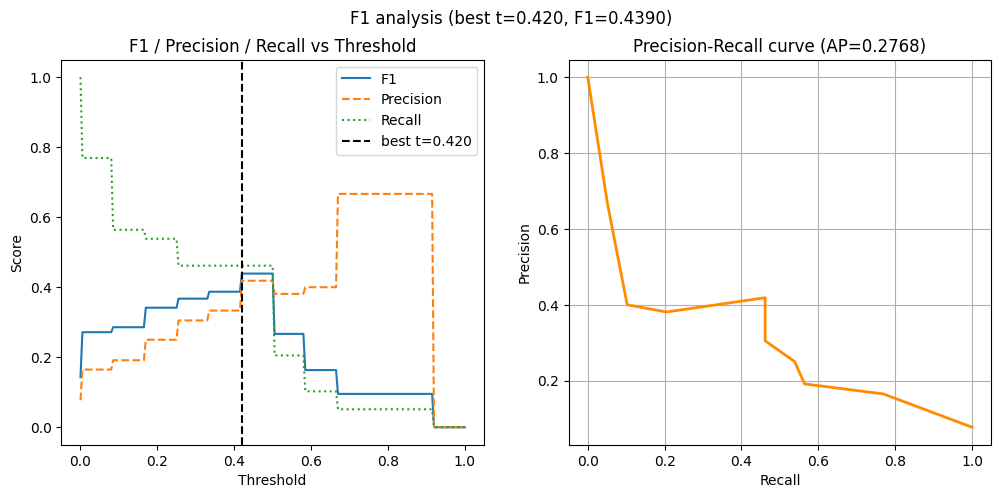

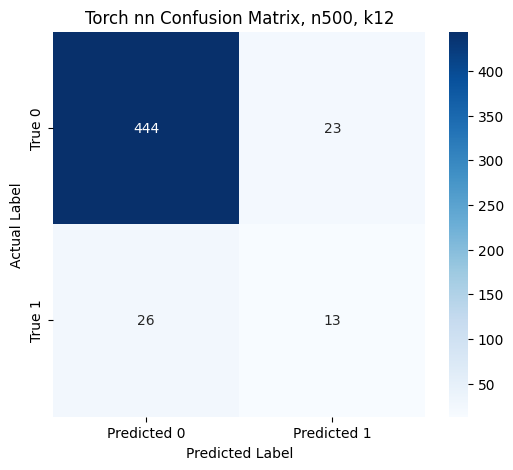

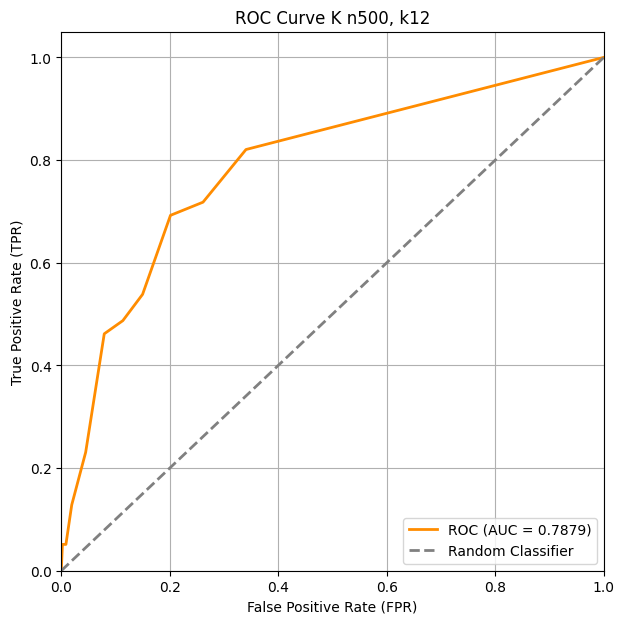

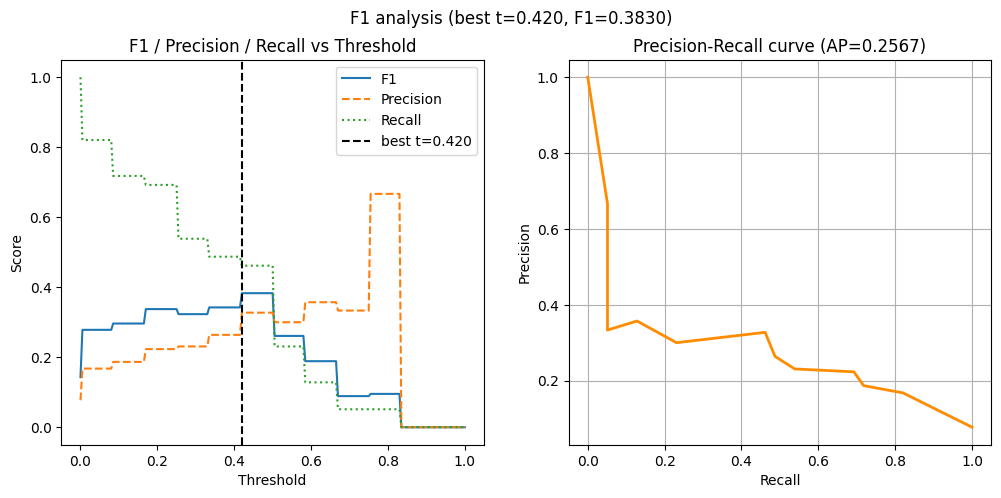

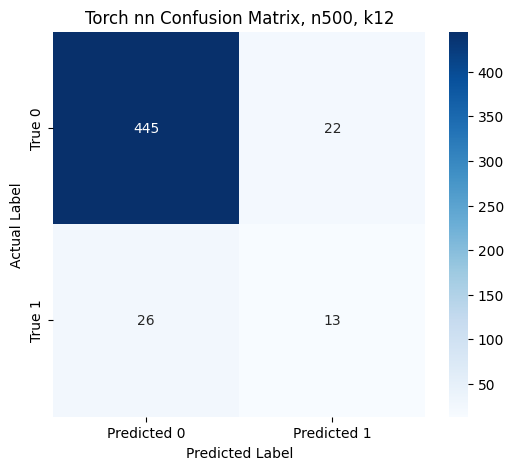

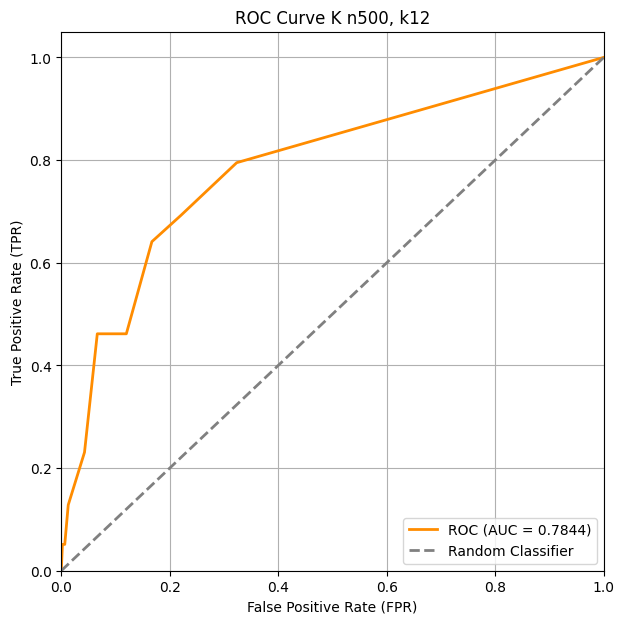

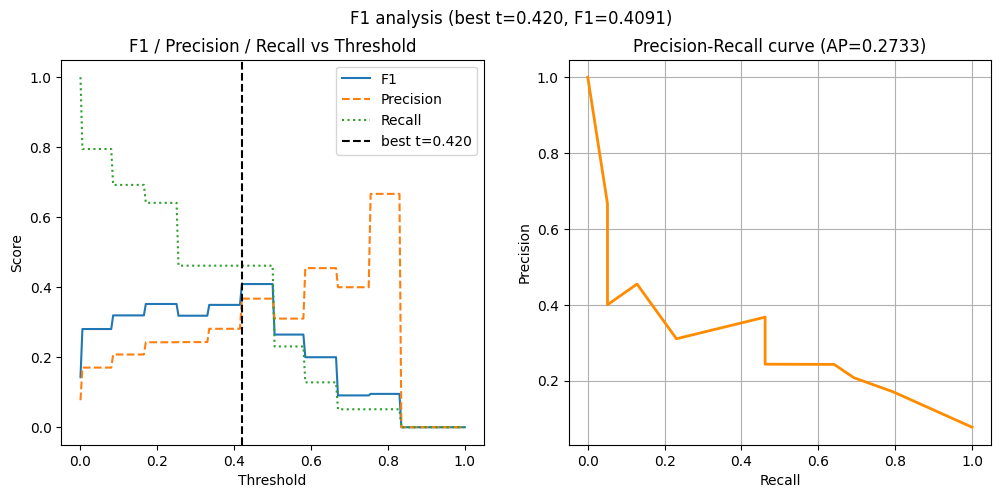

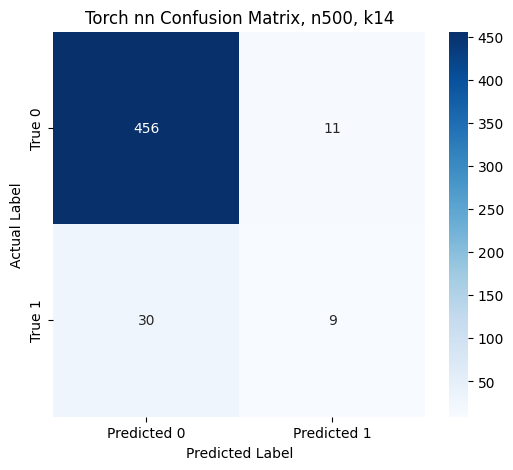

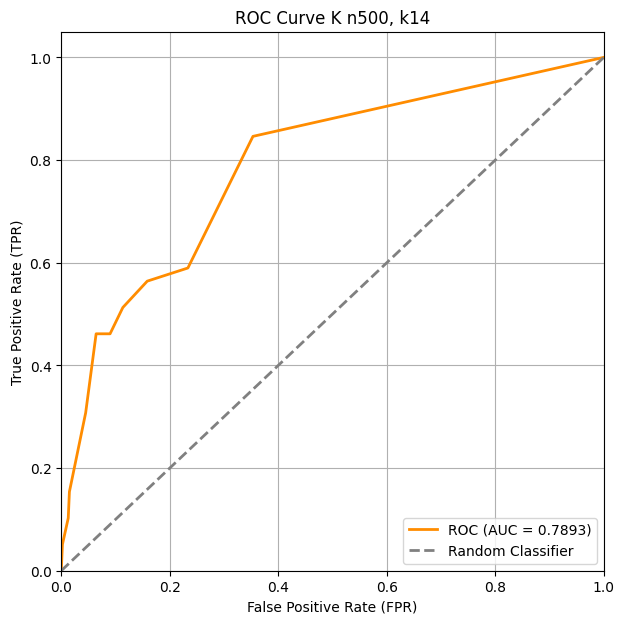

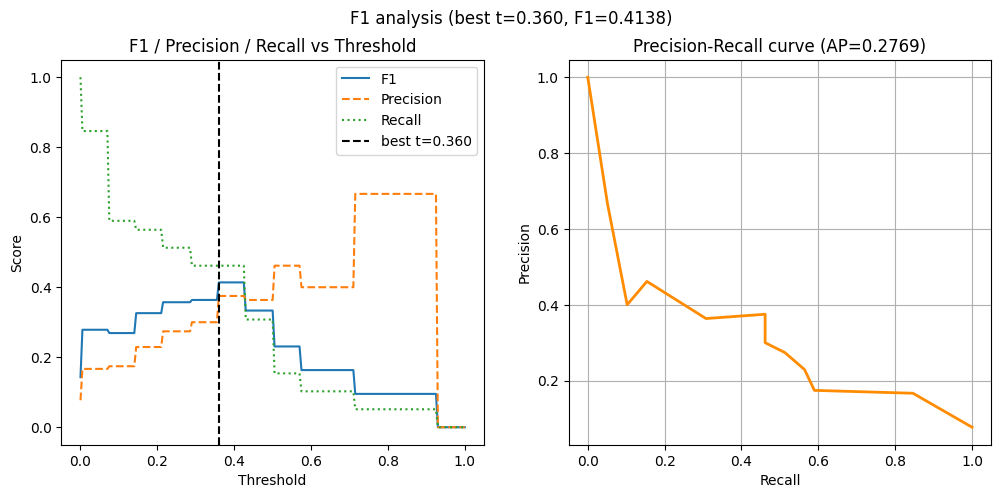

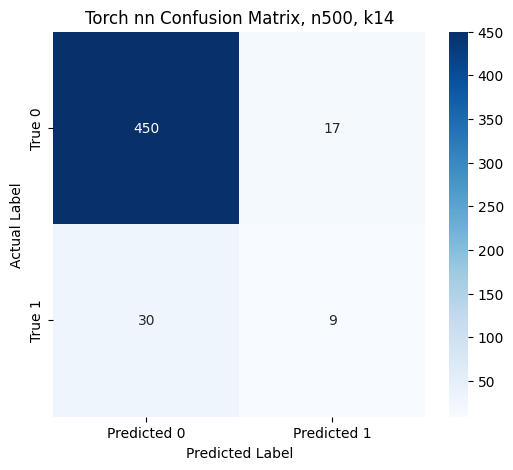

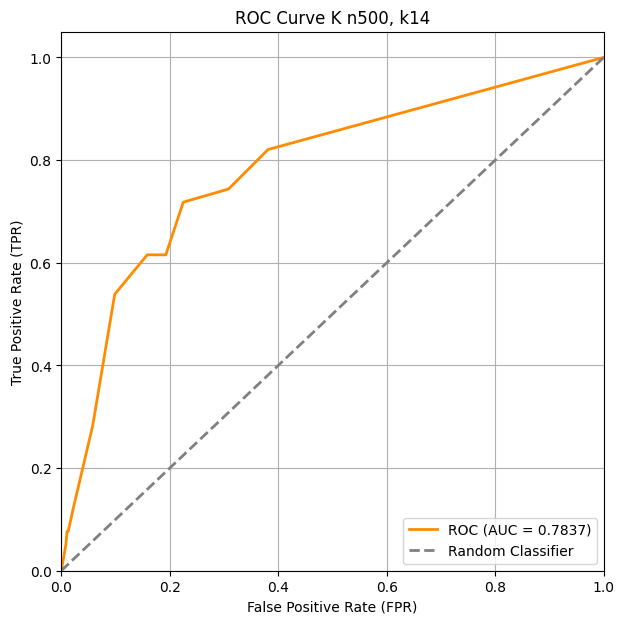

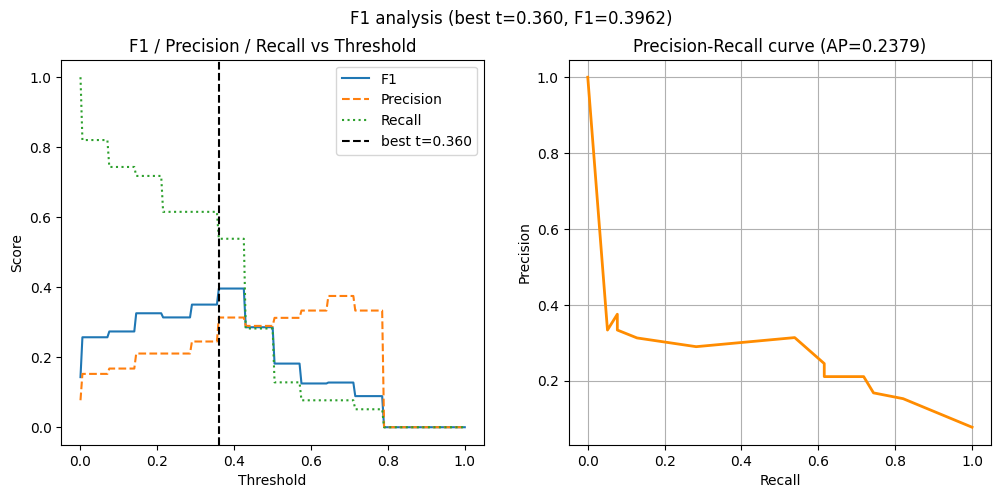

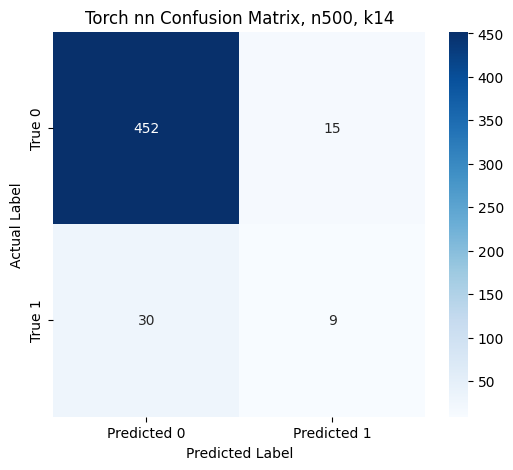

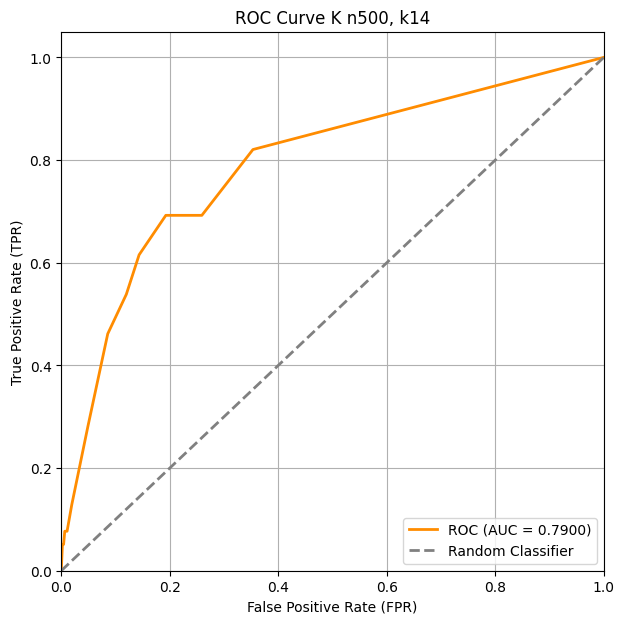

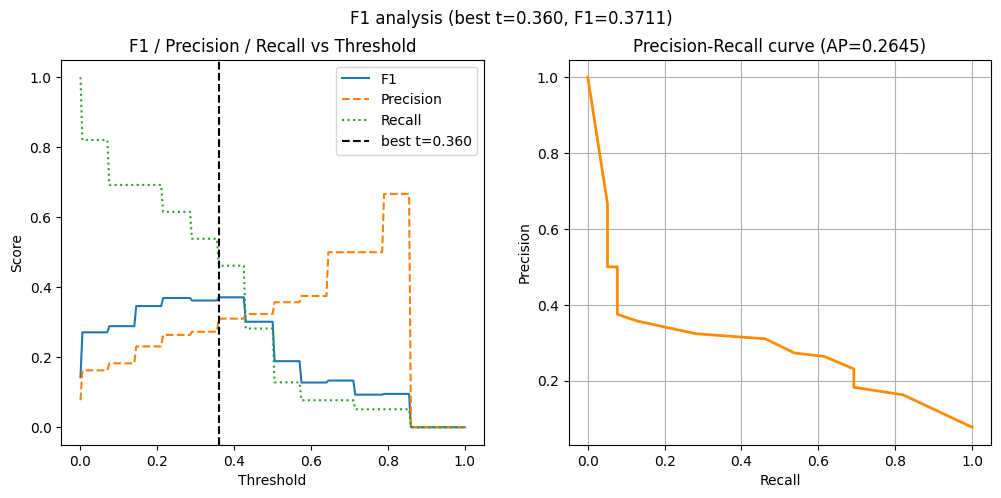

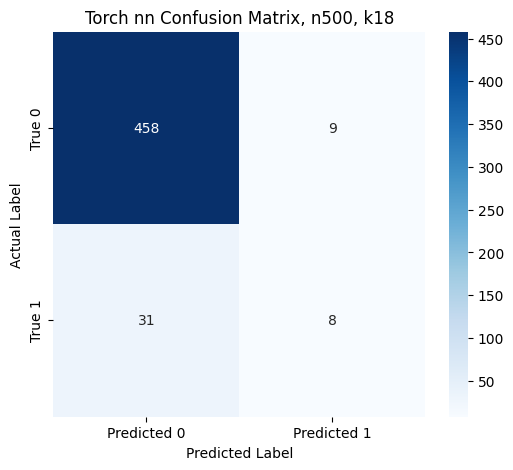

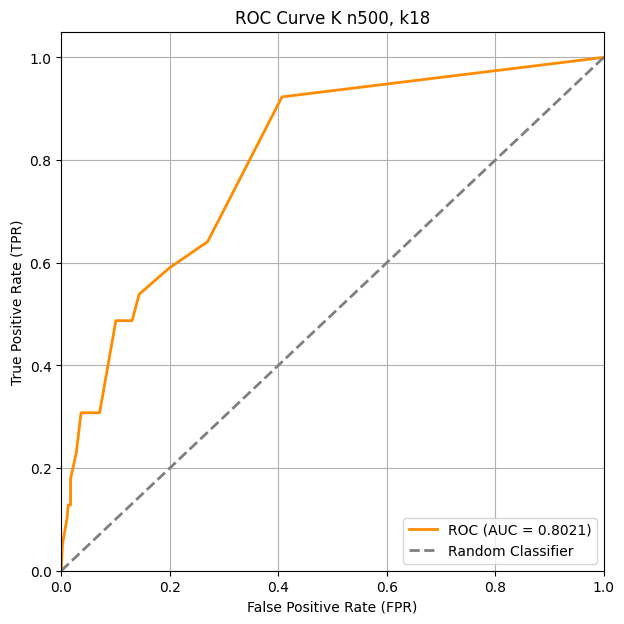

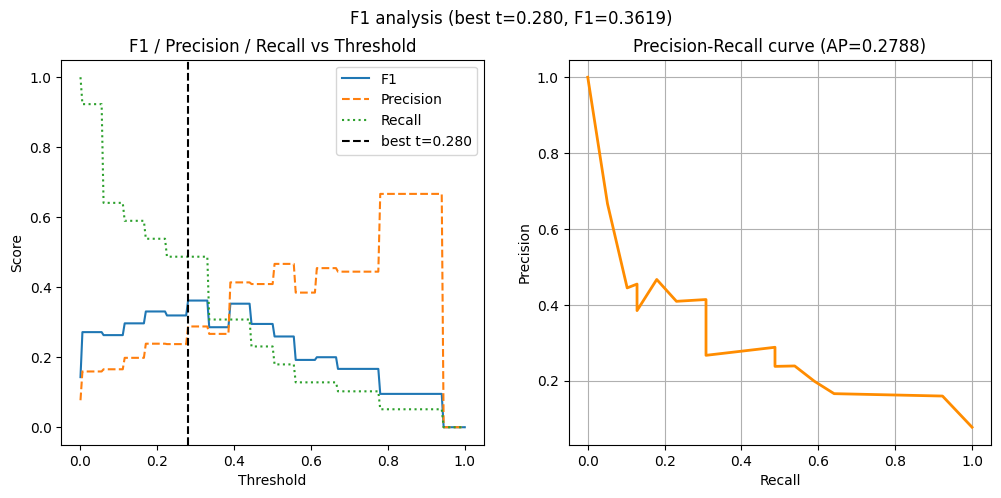

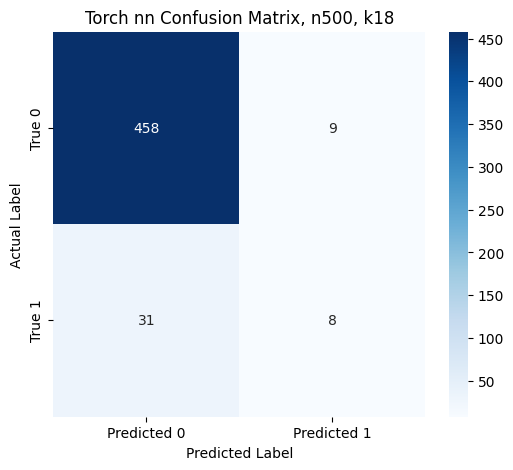

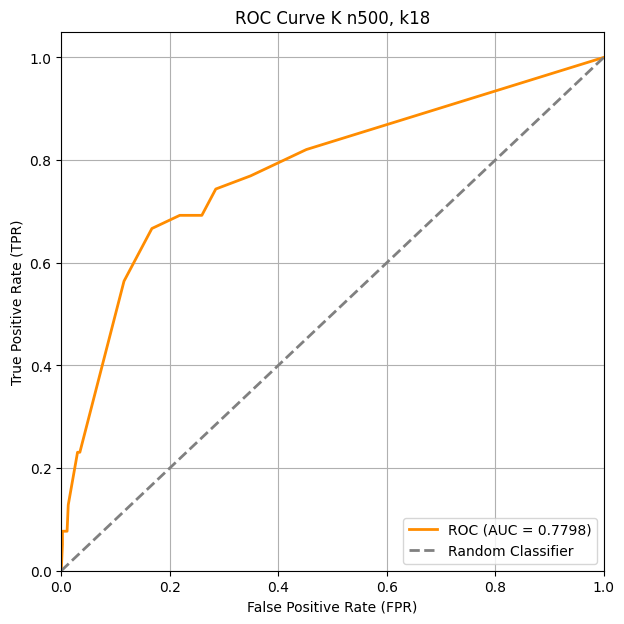

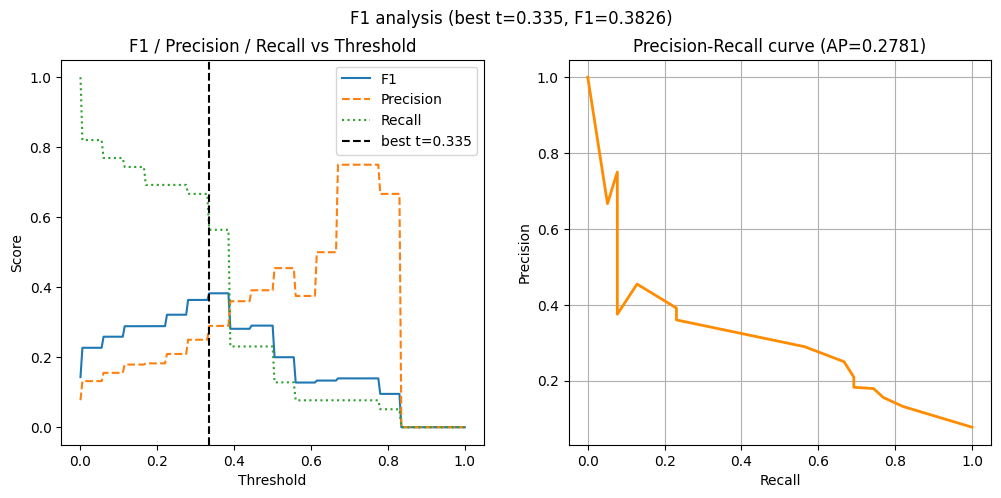

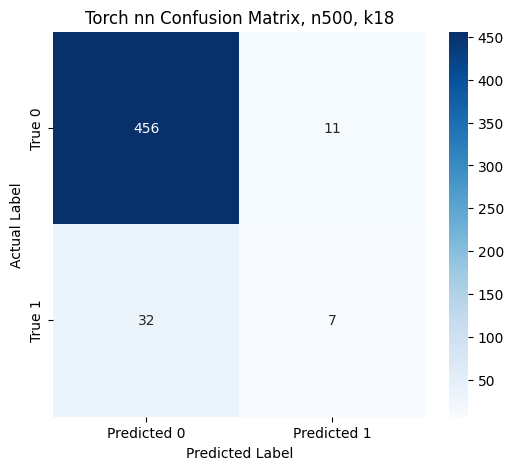

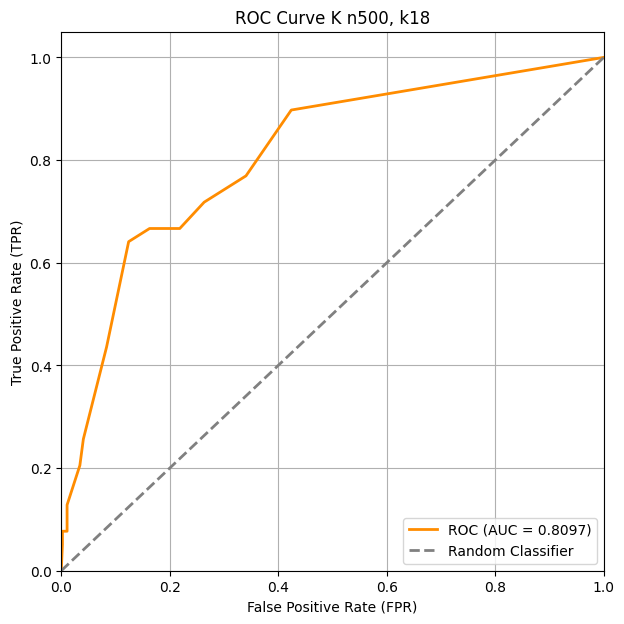

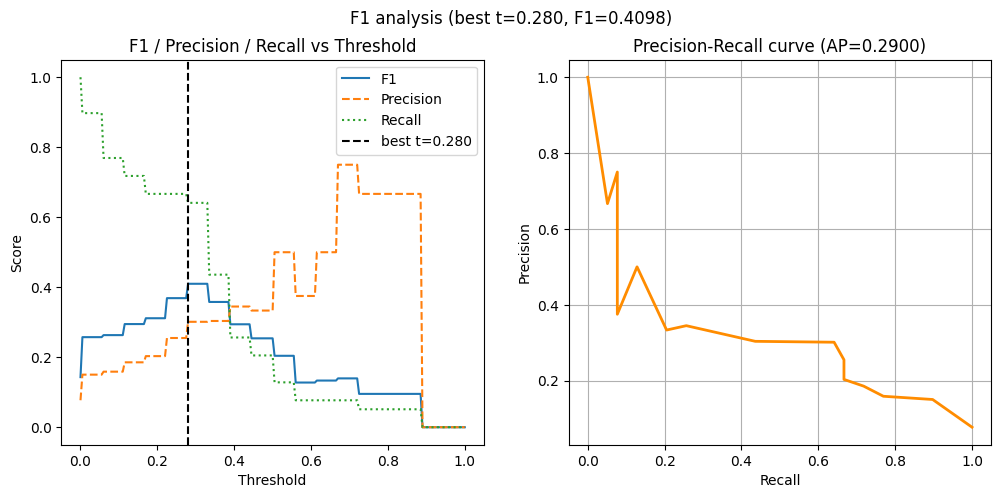

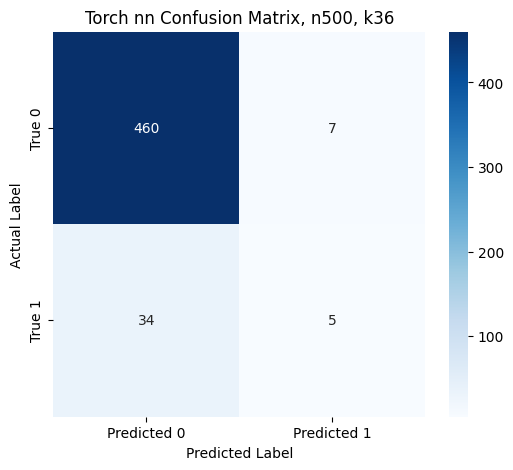

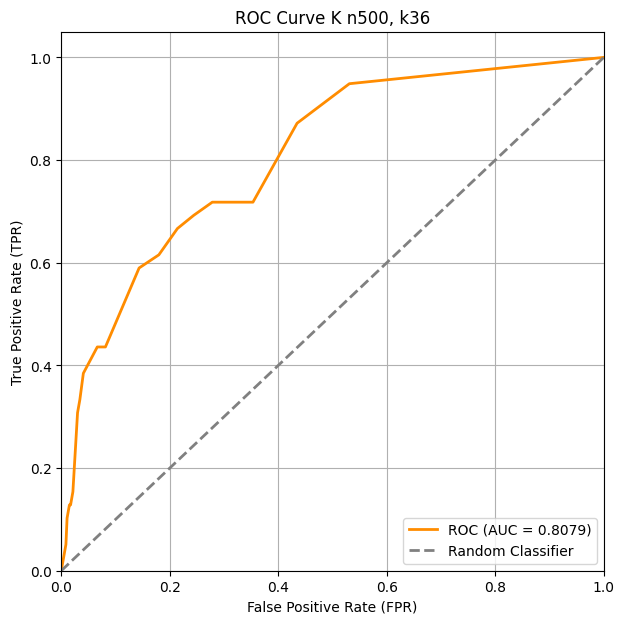

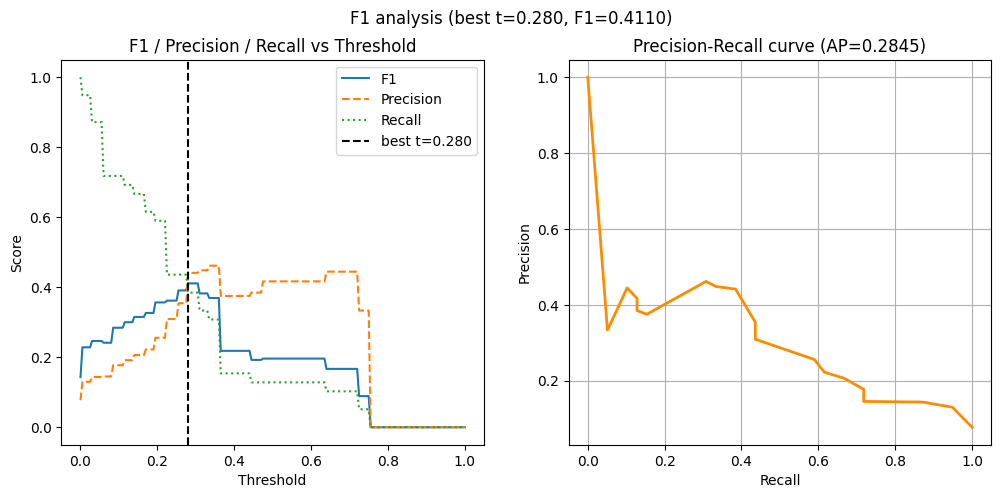

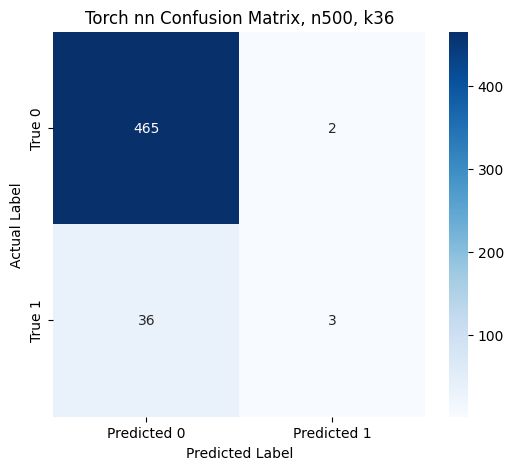

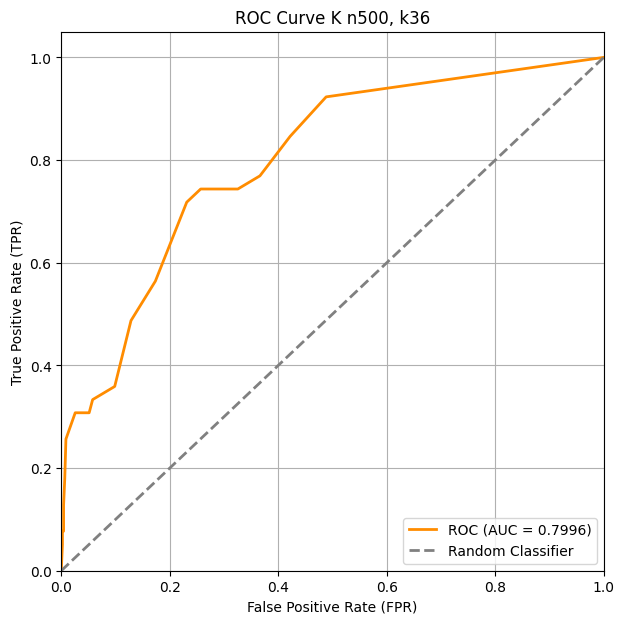

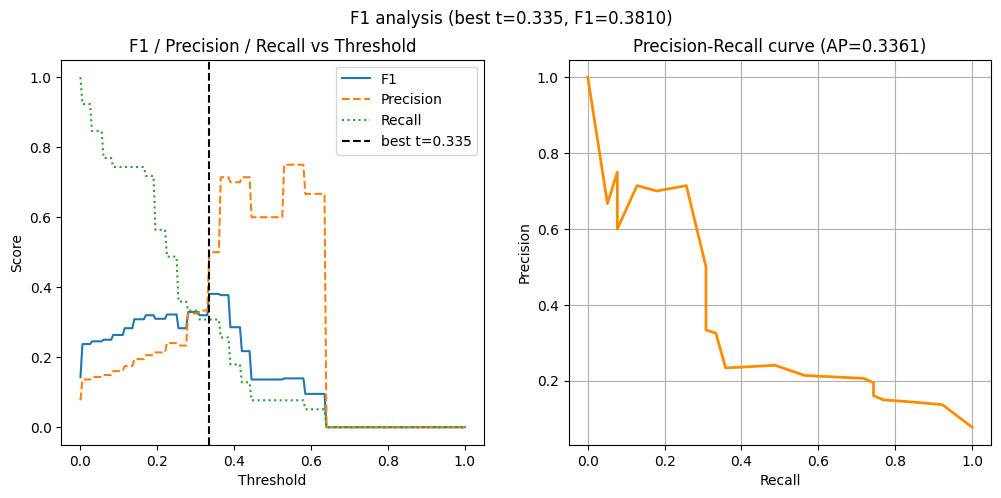

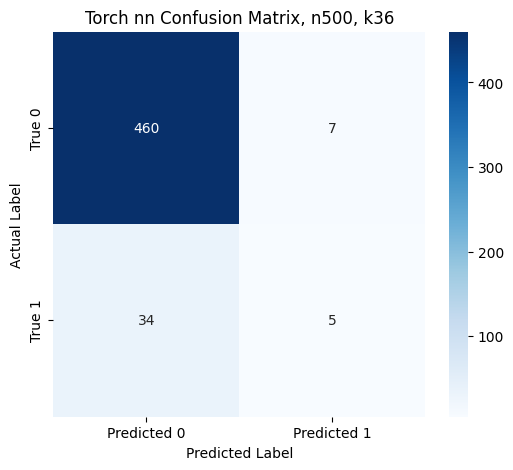

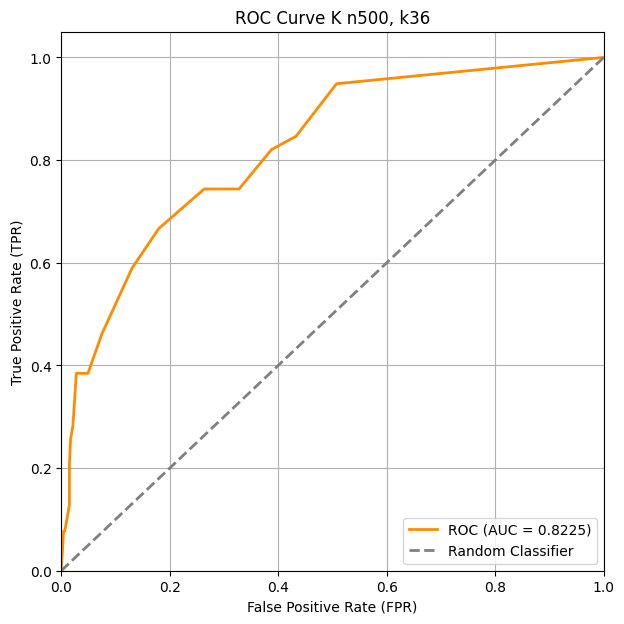

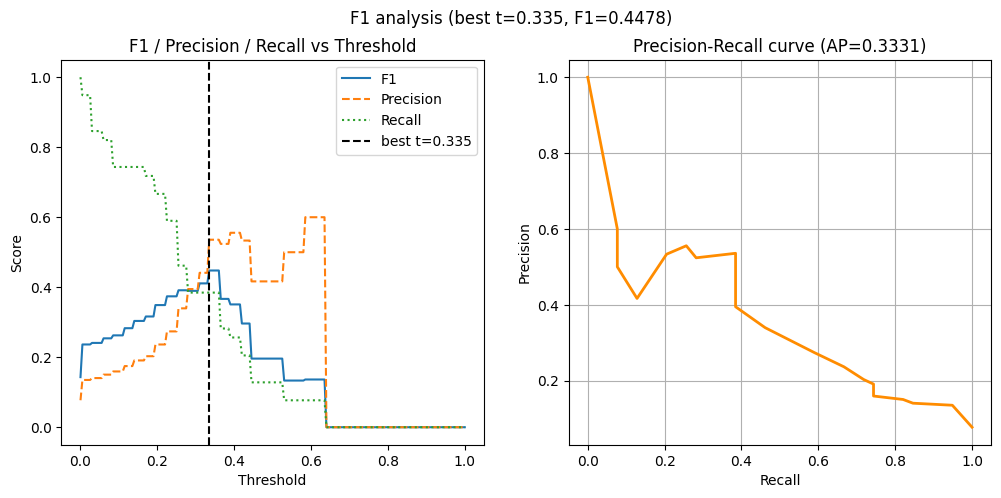

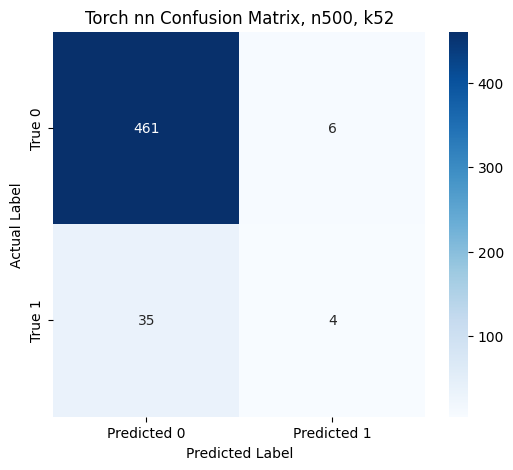

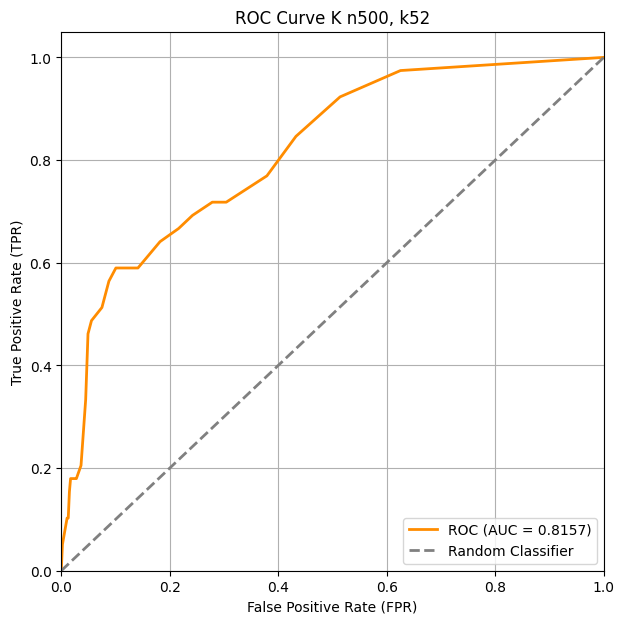

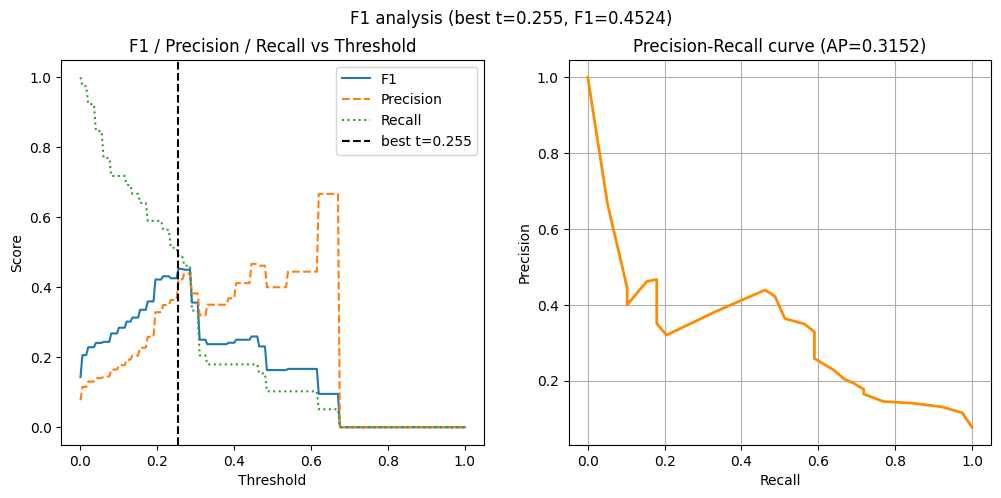

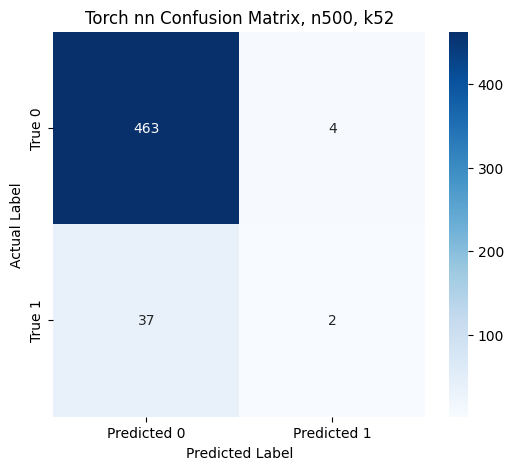

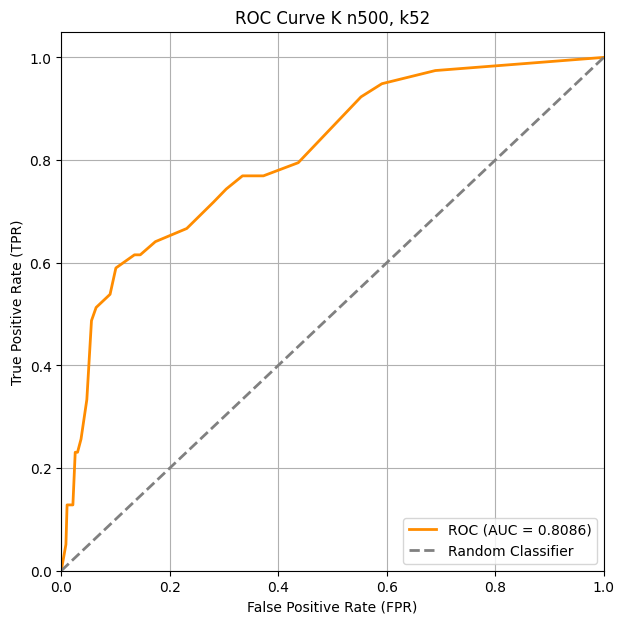

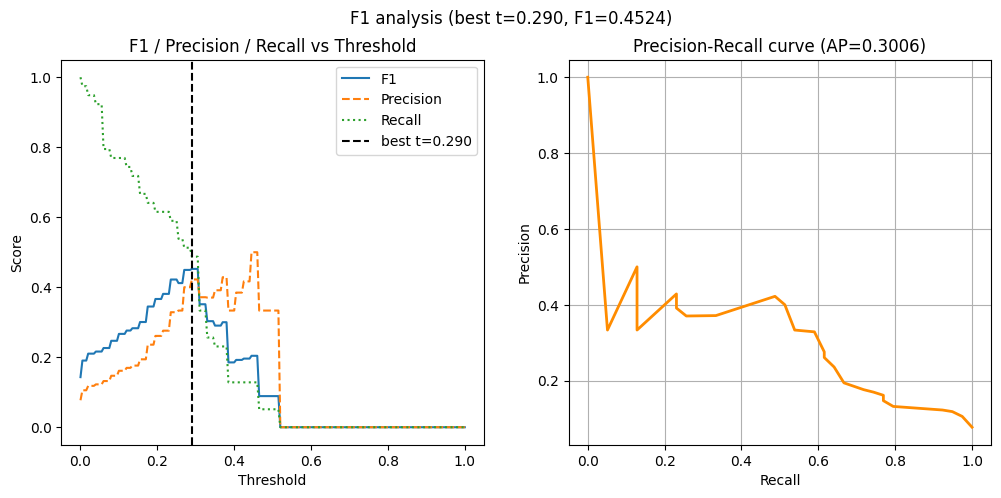

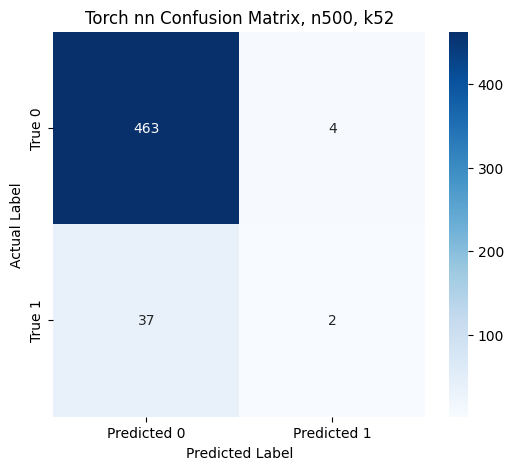

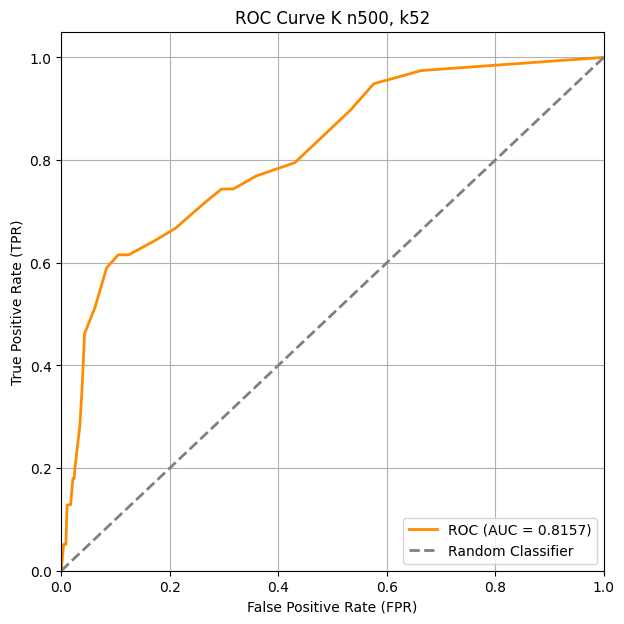

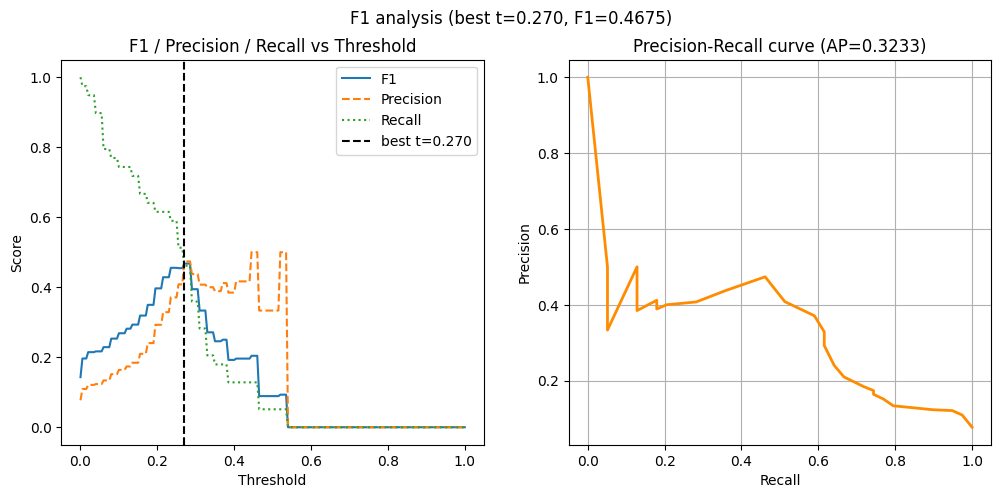

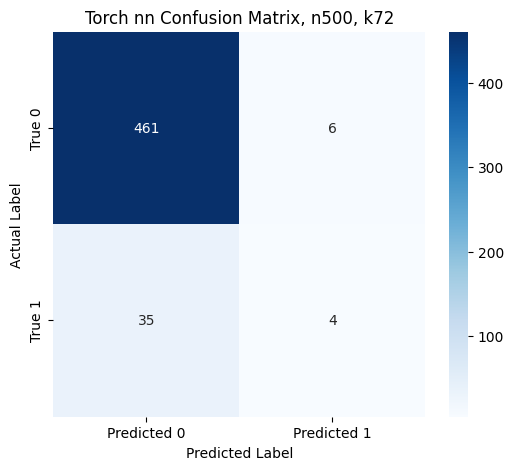

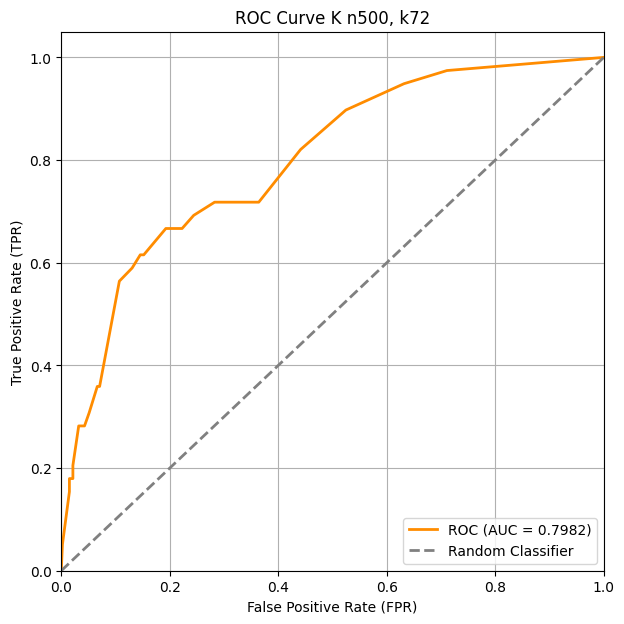

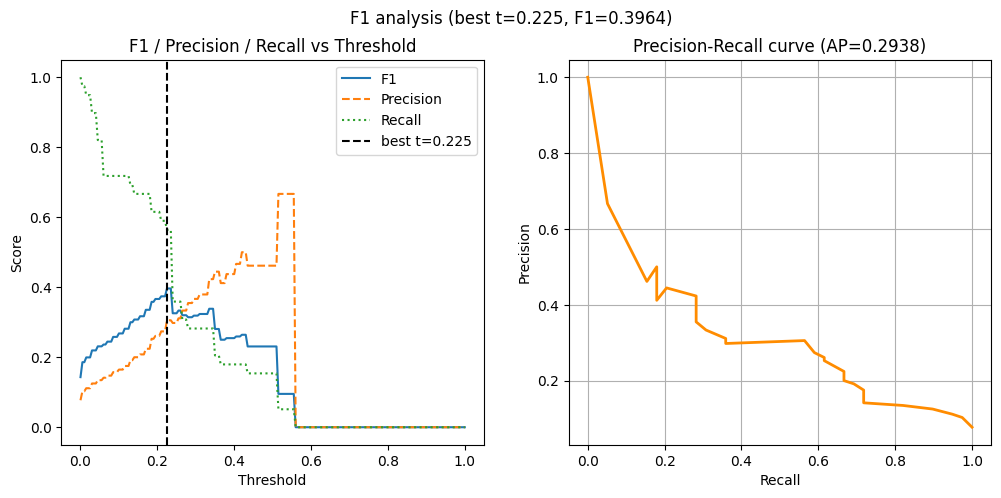

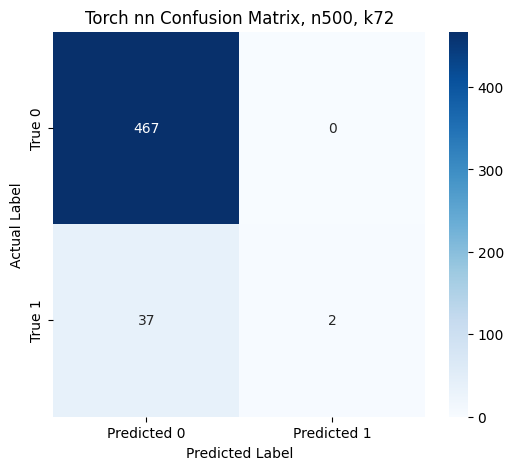

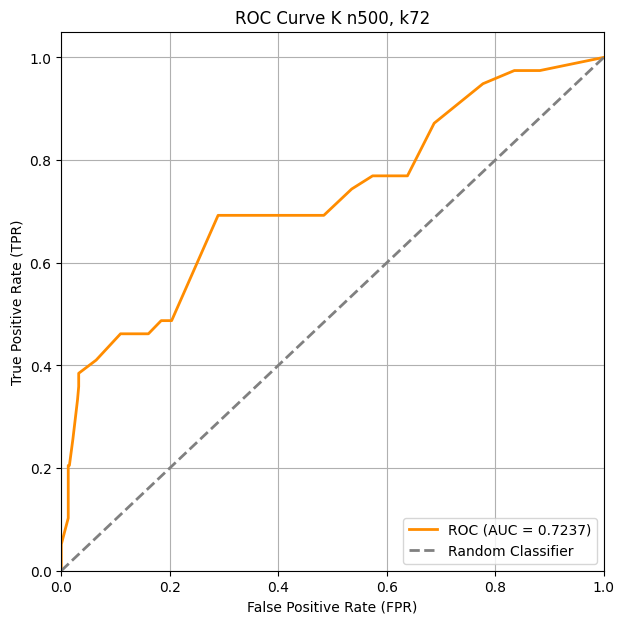

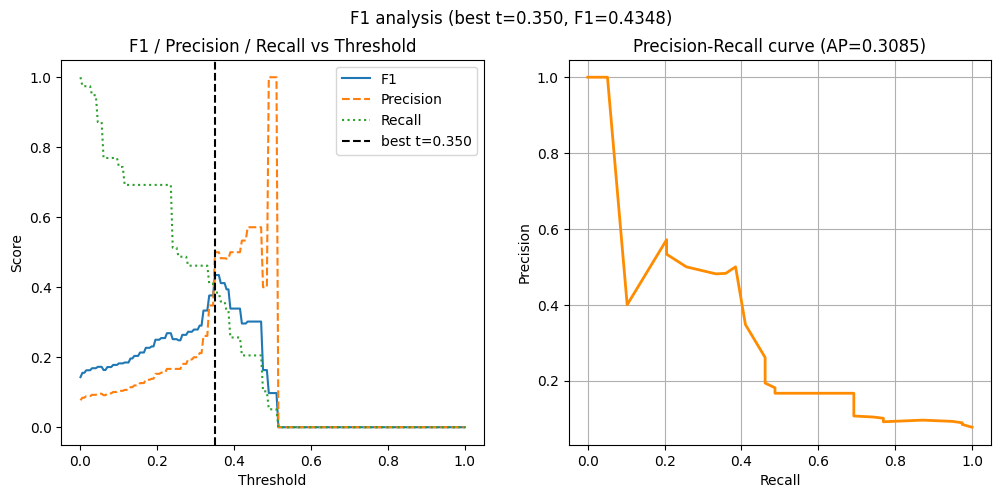

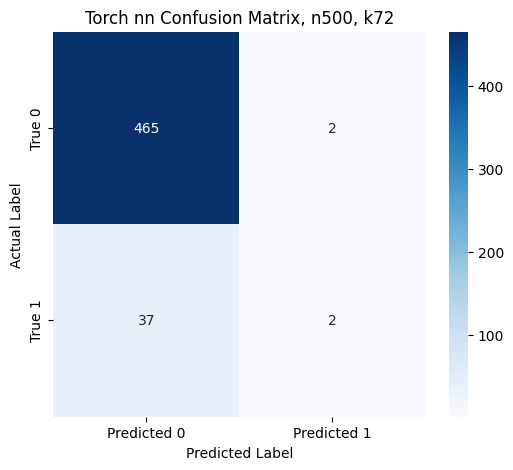

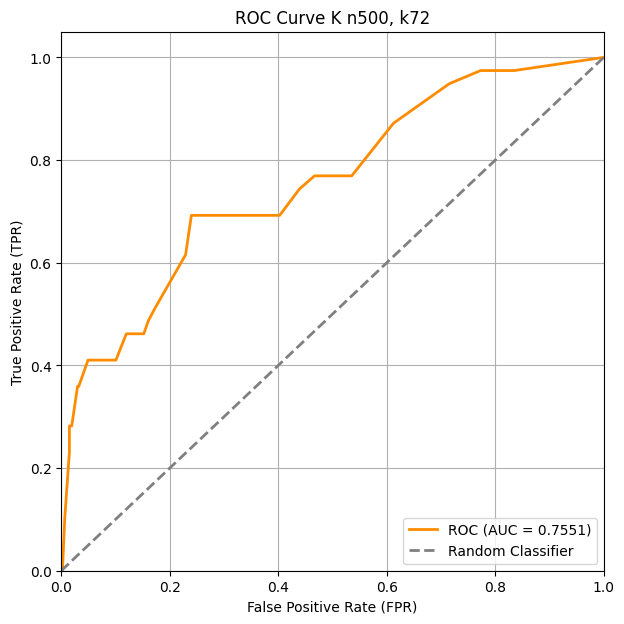

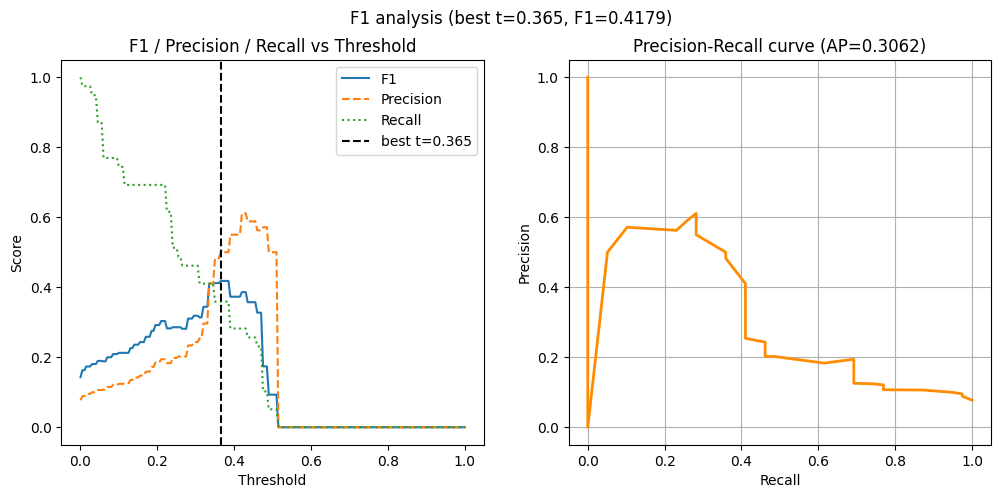

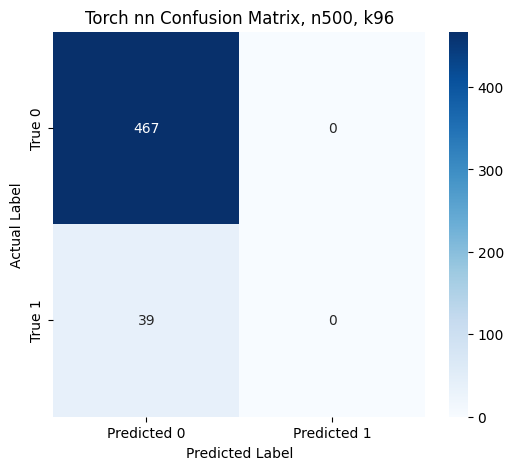

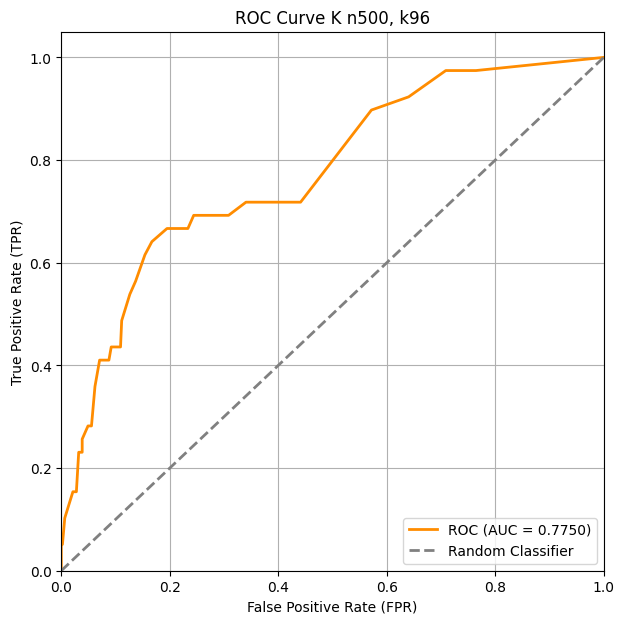

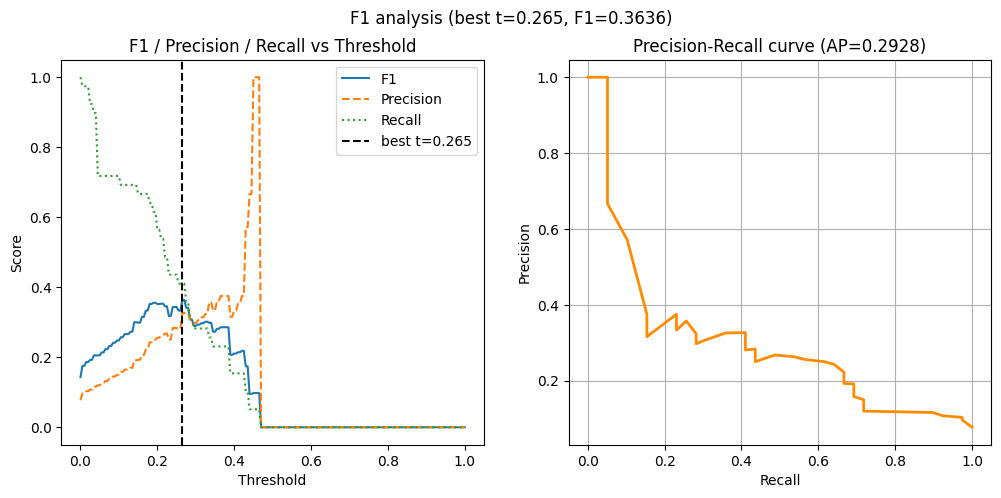

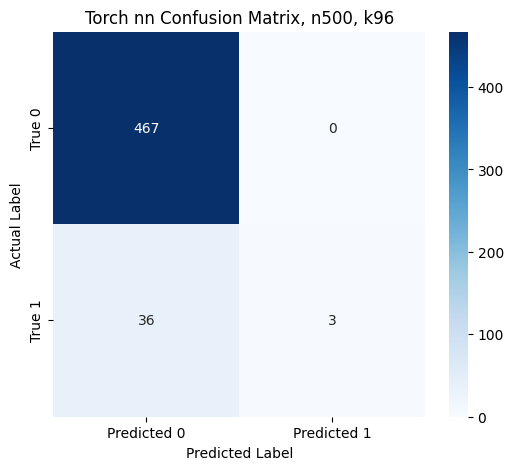

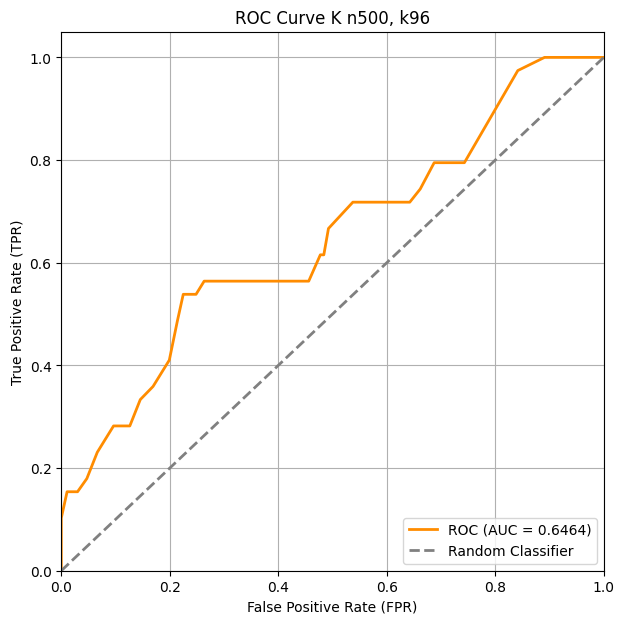

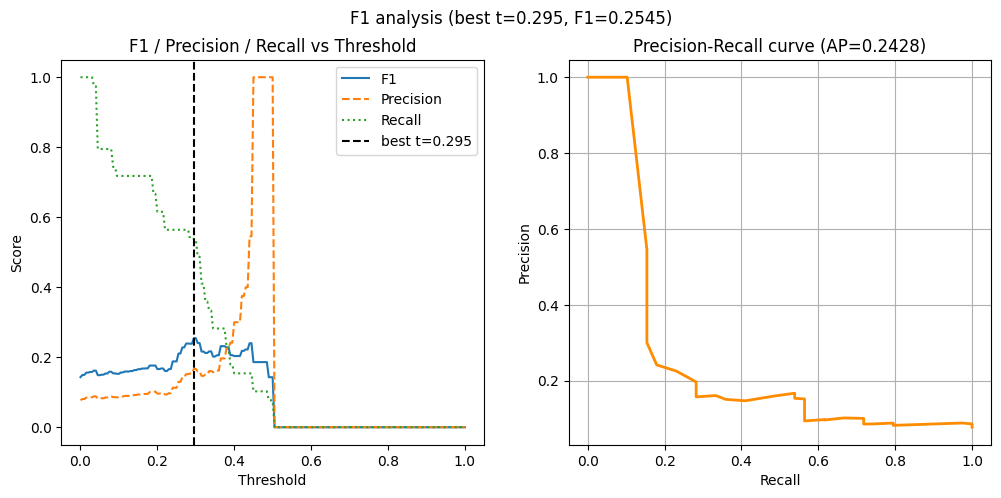

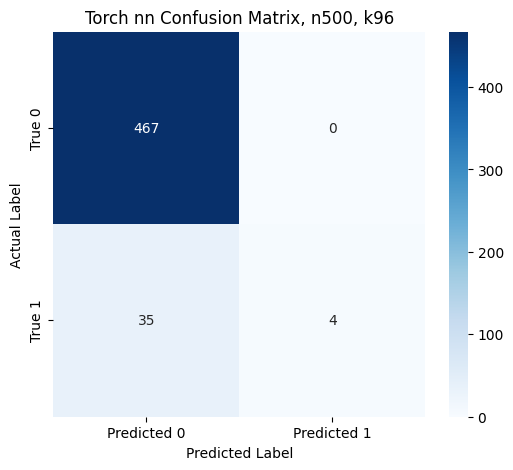

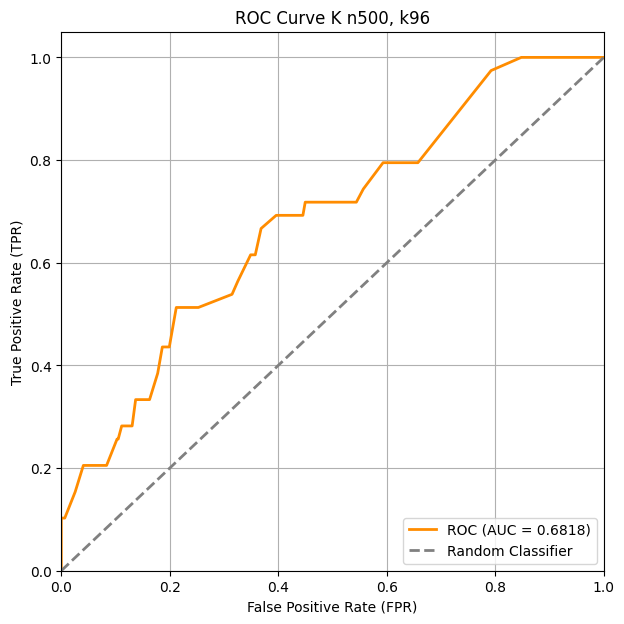

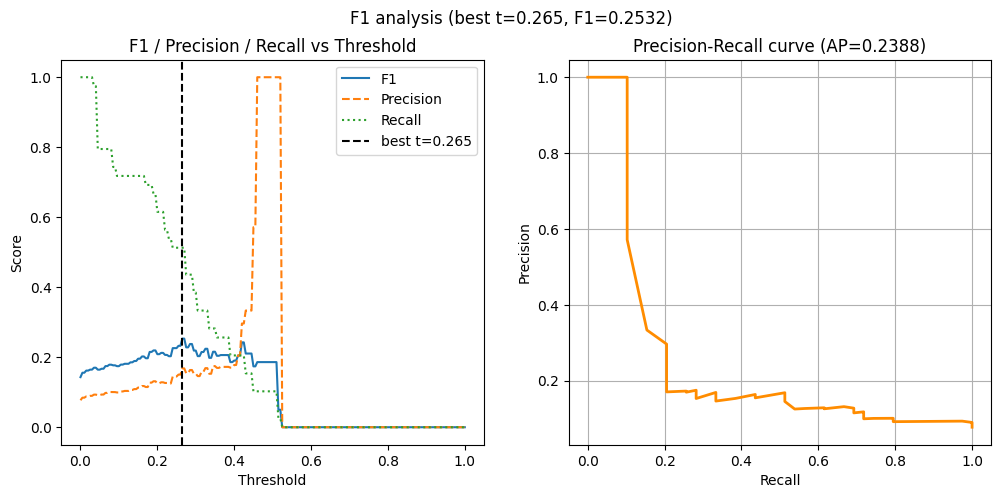

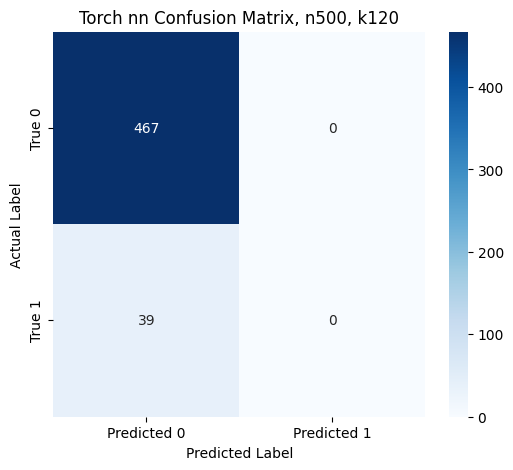

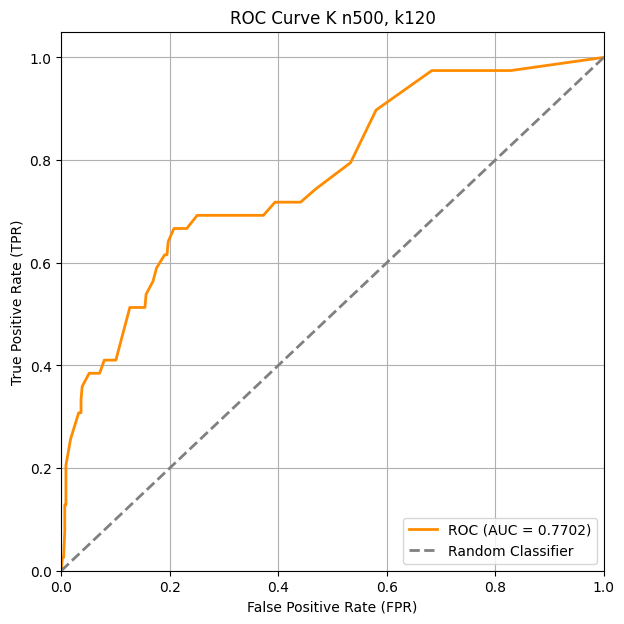

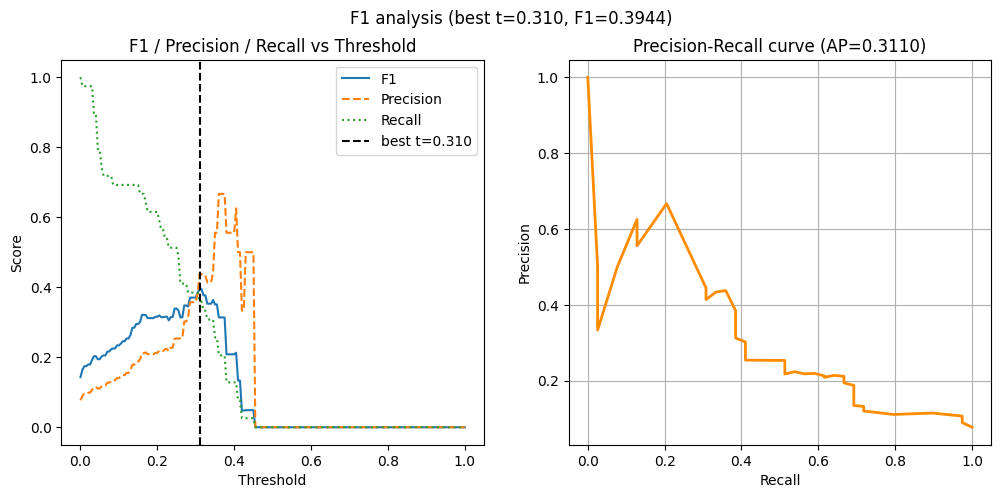

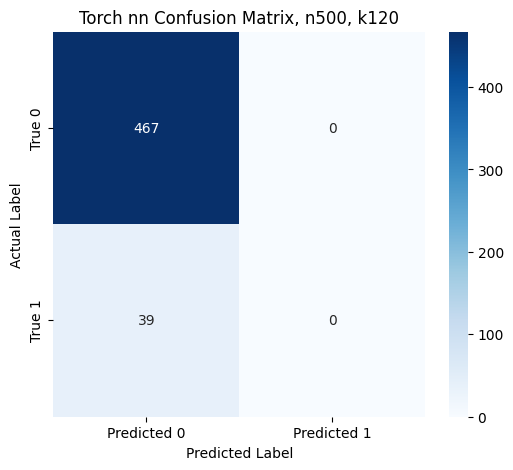

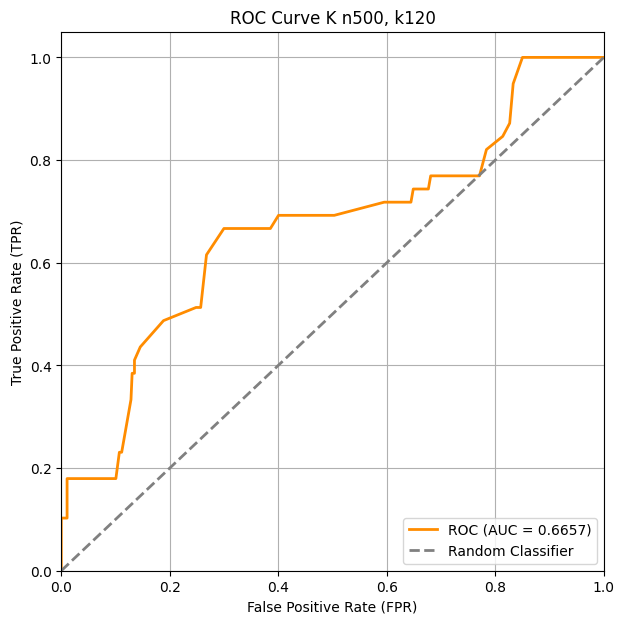

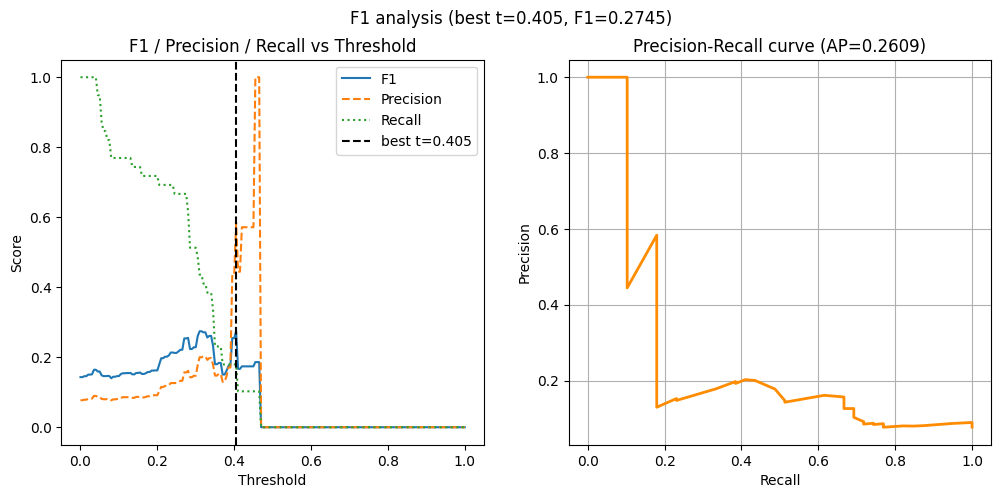

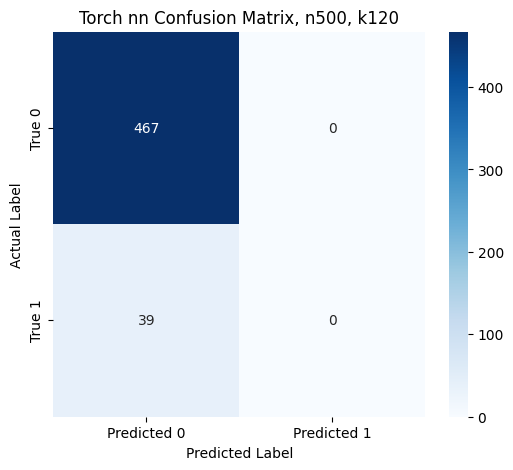

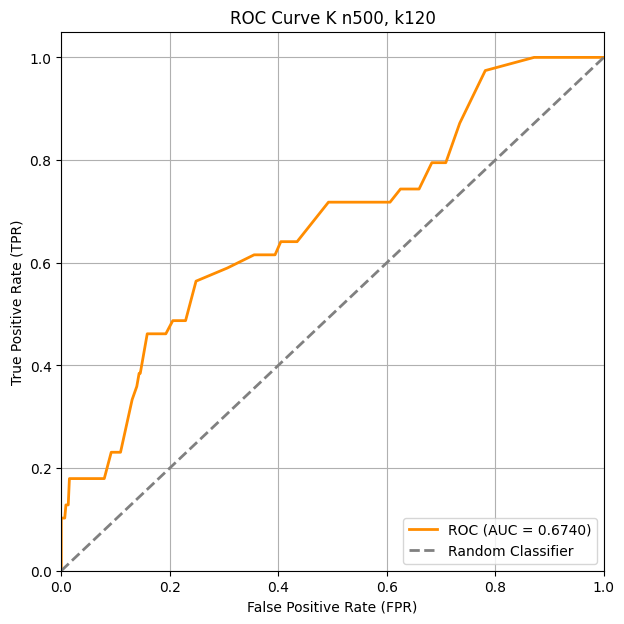

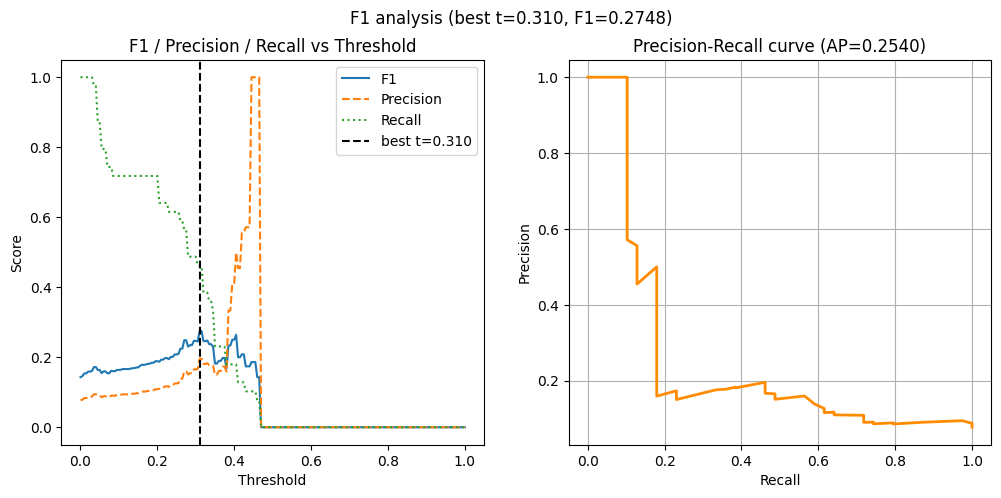

In [14]:
### Requires to have run the first chunk at the top ###

# Computationally expensive - run only once
collect_results = pd.DataFrame(columns=["k", "distance_metric", "accuracy", "confusion_mat", "labels"])
for k in [2, 4, 8, 12, 14, 18, 36, 52, 72, 96, 120]:
    for dist in ["hamming", "euclidean", "manhattan"]:
        print(f"\nIteration started on - k: {k}, dist: {dist}")
        knn_out_dir = nn_run_dir + f"knn_k{k}_{dist}/"
        
        ### Ensure base run dir exists and knn_out_dir is inside it, then create knn_out_dir if missing ###
        if os.path.commonpath([os.path.abspath(nn_run_dir), os.path.abspath(knn_out_dir)]) != os.path.abspath(nn_run_dir):
            raise ValueError(f"{knn_out_dir} is not inside base nn_run_dir {nn_run_dir!r}")
        
        if not os.path.exists(knn_out_dir):
            os.makedirs(knn_out_dir, exist_ok=True)
            print(f"Created directory: {knn_out_dir}. Writing new files...")
        else:
            print(f"Directory exists: {knn_out_dir}. Overwriting files...")       
        
        ### Runnning the parameters, saving output to collect_results ###
        with open(knn_out_dir+f"logfile_k{k}_{dist}.txt", "w") as curr_logfile:
            KNNclass = KNNClassifier(X_train, y_train, 
                                    knn_out_dir, curr_logfile,
                                    k=k, silent=True, 
                                    distance_metric=dist)
            eval_status = KNNclass.eval(X_test, y_test)
            
            if eval_status["STATUS"] == 1:
                print("Model failed to eval...")
                continue
            
            accuracy = KNNclass.accuracy()
            cm, labels = KNNclass.confusion_matrix()
            print(f"KNN Classifier (k={k}, distance={dist}) Accuracy on Test Set: {accuracy*100:.2f}%\nConfusion matrix:\n{cm}\nLabels:{labels}")

            #Running and automatically saving KNN performance plots
            KNNclass.plot_confusion_matrix(cm)
            KNNclass.plot_roc_curve()
            f1_status = KNNclass.f1_from_module(y_test)
            if f1_status["STATUS"] == 1:
                print("Model failed perform f1 analysis, continuing without...")
            
            print("All analysis complete, starting data collection...")
            collect_results = pd.concat([collect_results, 
                                        pd.DataFrame({"k": [k], 
                                                    "distance_metric": [dist], 
                                                    "accuracy": [accuracy],
                                                    "confusion_mat": [cm.flatten()], 
                                                    "labels": [labels]})],
                                        ignore_index=True)
        print(f"Collection for k: {k}, dist: {dist}\n") #print newline
collect_results.to_csv(nn_run_dir + "knn_hyperparameter_search_results.csv", index=False)

#### Comparing results

In [15]:
collect_results = pd.read_csv(nn_run_dir + "knn_hyperparameter_search_results.csv")
collect_results = collect_results.sort_values(by="k", ascending=True).reset_index(drop=True)
display(collect_results)

k distance_metric  accuracy      confusion_mat labels
0     2         hamming  0.913043  [447  20  24  15]  [0 1]
1     2       euclidean  0.911067  [445  22  23  16]  [0 1]
2     2       manhattan  0.899209  [440  27  24  15]  [0 1]
3     4         hamming  0.926877  [453  14  23  16]  [0 1]
4     4       euclidean  0.911067  [445  22  23  16]  [0 1]
5     4       manhattan  0.913043  [446  21  23  16]  [0 1]
6     8         hamming  0.920949  [452  15  25  14]  [0 1]
7     8       euclidean  0.907115  [445  22  25  14]  [0 1]
8     8       manhattan  0.915020  [449  18  25  14]  [0 1]
9    12         hamming  0.915020  [451  16  27  12]  [0 1]
10   12       euclidean  0.903162  [444  23  26  13]  [0 1]
11   12       manhattan  0.905138  [445  22  26  13]  [0 1]
12   14         hamming  0.918972  [456  11  30   9]  [0 1]
13   14       euclidean  0.907115  [450  17  30   9]  [0 1]
14   14       manhattan  0.911067  [452  15  30   9]  [0 1]
15   18       manhattan  0.915020  [456  11  32   7]  [0 1]
16   18       euclidean  0.920949  [458   9  31   8]  [0 1]
17   18         hamming  0.920949  [458   9  31   8]  [0 1]
18   36         hamming  0.918972  [460   7  34   5]  [0 1]
19   36       euclidean  0.924901  [465   2  36   3]  [0 1]
20   36       manhattan  0.918972  [460   7  34   5]  [0 1]
21   52         hamming  0.918972  [461   6  35   4]  [0 1]
22   52       euclidean  0.918972  [463   4  37   2]  [0 1]
23   52       manhattan  0.918972  [463   4  37   2]  [0 1]
24   72         hamming  0.918972  [461   6  35   4]  [0 1]
25   72       euclidean  0.926877  [467   0  37   2]  [0 1]
26   72       manhattan  0.922925  [465   2  37   2]  [0 1]
27   96         hamming  0.922925  [467   0  39   0]  [0 1]
28   96       euclidean  0.928854  [467   0  36   3]  [0 1]
29   96       manhattan  0.930830  [467   0  35   4]  [0 1]
30  120         hamming  0.922925  [467   0  39   0]  [0 1]
31  120       euclidean  0.922925  [467   0  39   0]  [0 1]
32  120       manhattan  0.922925  [467   0  39   0]  [0 1]

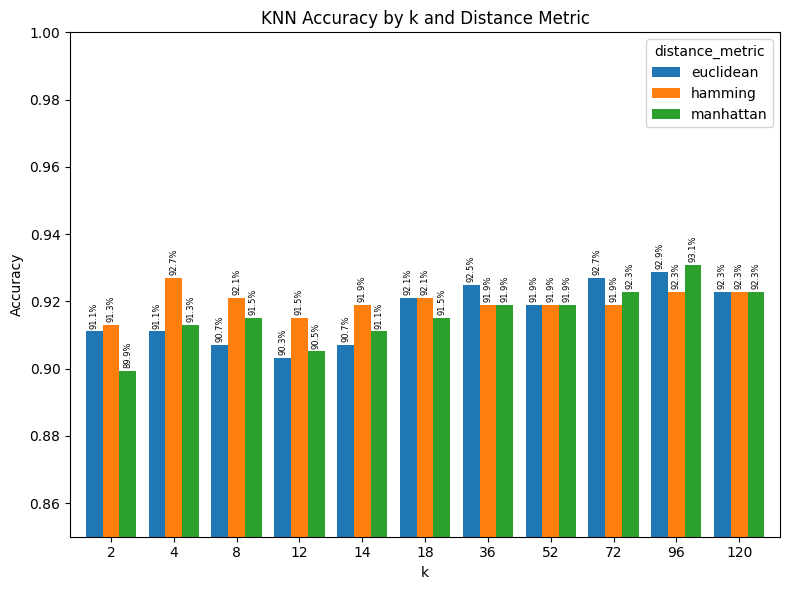

In [16]:
import matplotlib.pyplot as plt

# ensure k is numeric and sorted
collect_results['k'] = collect_results['k'].astype(int)
pivot = collect_results.pivot(index='k', columns='distance_metric', values='accuracy').sort_index()

# plot grouped bar chart
ax = pivot.plot(kind='bar', figsize=(8,6), width=0.8)
ax.set_xlabel('k')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_ylabel('Accuracy')
ax.set_ylim(0.85, 1)
ax.set_title('KNN Accuracy by k and Distance Metric')
ax.legend(title='distance_metric', loc='upper right')

# annotate bars with percentages
for p in ax.patches:
    h = p.get_height()
    if not np.isnan(h):
        x = p.get_x() + p.get_width() / 2
        y = h
        ax.annotate(f'{h*100:.1f}%', xy=(x, y), xytext=(0, 2),
                    textcoords='offset points', ha='center', va='bottom',
                    fontsize=6, rotation=90)

plt.tight_layout()
plt.savefig(nn_run_dir + "knn_accuracy_comparison.png", dpi=300)
plt.show()

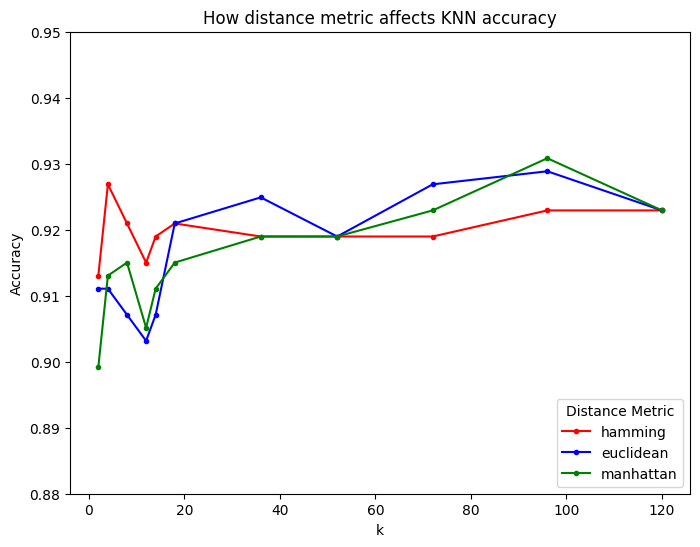

In [18]:
fig = plt.figure(figsize=(8,6))
# color dictionary for distance metrics
color_dict = {
    'hamming': 'r',
    'euclidean': 'b',
    'manhattan': 'g',
}
# plot lines for each distance metric
for dist in collect_results['distance_metric'].unique():
    subset = collect_results[collect_results['distance_metric'] == dist]
    plt.plot(subset['k'], subset['accuracy'], marker='.', label=dist, color=color_dict[dist])

plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('How distance metric affects KNN accuracy')
plt.ylim(0.88, 0.95)
plt.legend(title='Distance Metric', loc='lower right')
plt.savefig(nn_run_dir + "knn_accuracy_distance_metric_comparison.png", dpi=300)
plt.show()

### Performance for all collected data: Confusion matrix, F1-analysis, ROC curves 